# Setup

In [1]:

def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    plot_args = {
        'width': 800,
        'height': 600,
        "autosize": False,
        'showlegend': True,
        'margin': {"l":0,"r":0,"t":100,"b":0}
    }
    
    fig.update_layout(**plot_args)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
    if show:
        fig.show(renderer)
    else:
        return fig


# idea:
# do in higher precision because things are so smol


In [2]:
# requires
# pip install git+https://github.com/Phylliida/MambaLens.git

from mamba_lens import HookedMamba # this will take a little while to import
import torch
model_path = "state-spaces/mamba-370m"

# NOTE! We need to monkeypatch transformer lens to use register_full_backward_hook
model = HookedMamba.from_pretrained(model_path, device='cuda')
torch.set_grad_enabled(False)


/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


## Load SAEs

In [3]:

from safetensors.torch import load_file
from collections import defaultdict

import sys
if not "/home/dev/sae-k-sparse-mamba/sae" in sys.path:
    sys.path.append("/home/dev/sae-k-sparse-mamba")
import os
os.chdir('/home/dev/sae-k-sparse-mamba')
saes = [None]
from importlib import reload
from sae.sae import Sae

ckpt_dir = "/home/dev/sae-k-sparse-mamba/"
for i in range(1,22):
    print(i)
    hook = f'blocks.{i}.hook_out_proj'
    path = [ckpt_dir + f for f in sorted(list(os.listdir(ckpt_dir))) if hook in f][0] + "/" + f'hook_{hook}.pt'
    #path = f'/home/dev/sae-k-sparse-mamba/blocks.{i}.hook_resid_pre/hook_blocks.{i}.hook_resid_pre.pt'
    print(path)
    saes.append(Sae.load_from_disk(path, hook=f'blocks.{i}.hook_resid_pre', device=model.cfg.device))
    


1
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry190.txtblocks.1.hook_out_proj/hook_blocks.1.hook_out_proj.pt
2
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry191.txtblocks.2.hook_out_proj/hook_blocks.2.hook_out_proj.pt
3
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry192.txtblocks.3.hook_out_proj/hook_blocks.3.hook_out_proj.pt
4
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry193.txtblocks.4.hook_out_proj/hook_blocks.4.hook_out_proj.pt
5
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry194.txtblocks.5.hook_out_proj/hook_blocks.5.hook_out_proj.pt
6
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry195.txtblocks.6.hook_out_proj/hook_blocks.6.hook_out_proj.pt
7
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry196.txtblocks.7.hook_out_proj/hook_blocks.7.hook_out_proj.pt
8
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry200.txtblocks.8.hook_out_proj/hook_blocks.8.hook_out_proj.pt
9
/home/

In [76]:

from acdc.data.ioi import ioi_data_generator, ABC_TEMPLATES, get_all_single_name_abc_patching_formats
from acdc.data.utils import generate_dataset


def make_data(num_patching_pairs, patching, template_i, seed, valid_seed):
    constrain_to_answers = True
    # this makes our data size 800, first 400 is each (a,b) pair, and then second 400 is each pair swapped to be (b,a)
    has_symmetric_patching = True
    
    n1_patchings = ["""
    ABC BC A
    DBC BC D""",
        """
    ABC CB A
    DBC CB D"""]
    
    n2_patchings = ["""
    ABC AC B
    ADC AC D""",
        """
    ABC CA B
    ADC CA D"""]
    
    n3_patchings = ["""
    ABC AB C
    ABD AB D""",
        """
    ABC BA C
    ABD BA D"""]
    
    n4_patchings = ["""
    ABC AC B
    ABC BC A""",
        """
    ABC AB C
    ABC CB A""",
        """
    ABC BA C
    ABC CA B"""]
    
    n5_patchings = ["""
    ABC CA B
    ABC CB A
    """,
        """
    ABC BA C
    ABC BC A""",
        """
    ABC AB C
    ABC AC B"""]
    
    patchings = {
        'n1': n1_patchings,
        'n2': n2_patchings,
        'n3': n3_patchings,
        'n4': n4_patchings,
        'n5': n5_patchings
    }
    
    all_patchings = []
    for patching_set in patchings.values():
        all_patchings += patching_set
    all_patchings = sorted(all_patchings) # make deterministic 
    
    patch_all_names = ["""
    ABC AB C
    DEF DE F""",
        """
    ABC AC B
    DEF DF E""",     
        """
    ABC BA C
    DEF ED F""",
        """
    ABC BC A
    DEF EF D""",
        """
    ABC CA B
    DEF FD E""",
        """
    ABC CB A
    DEF FE D"""]
    
    
    patchings['all'] = all_patchings
    patchings['allatonce'] = patch_all_names
    from acdc.data.ioi import BABA_TEMPLATES
    templates = ABC_TEMPLATES
    #patching_formats = list(get_all_single_name_abc_patching_formats())
    PATCHING_FORMAT_I = patching
    patching_formats = ["\n".join([line.strip() for line in x.split("\n")]).strip() for x in patchings[PATCHING_FORMAT_I]]
    
    print("using patching format")
    for patch in patching_formats:
        print(patch)
        print("")
    #print(patching_formats)
    
    
    data = generate_dataset(model=model,
                      data_generator=ioi_data_generator,
                      num_patching_pairs=4,
                      seed=seed,
                      valid_seed=valid_seed,
                      constrain_to_answers=constrain_to_answers,
                      has_symmetric_patching=has_symmetric_patching, 
                      varying_data_lengths=True,
                      templates=templates,
                      patching_formats=patching_formats)
    
    
    import acdc.data.ioi
    from collections import defaultdict
    name_positions_map = defaultdict(lambda: [])
    for template in templates:
        name = acdc.data.ioi.good_names[0]
        template_filled_in = template.replace("[NAME]", name)
        template_filled_in = template_filled_in.replace("[PLACE]", acdc.data.ioi.good_nouns['[PLACE]'][0])
        template_filled_in = template_filled_in.replace("[OBJECT]", acdc.data.ioi.good_nouns['[OBJECT]'][0])
        # get the token positions of the [NAME] in the prompt
        name_positions = tuple([(i) for (i,s) in enumerate(model.to_str_tokens(torch.tensor(model.tokenizer.encode(template_filled_in)))) if s == f' {name}'])
        name_positions_map[name_positions].append(template)
    sorted_by_frequency = sorted(list(name_positions_map.items()), key=lambda x: -len(x[1]))
    most_frequent_name_positions, templates = sorted_by_frequency[0]
    print("using templates")
    templates = [templates[0]]
    for template in templates:
        print(template)
    print(f"with name positions {most_frequent_name_positions}")
    import acdc.data.ioi
    if 'Jesus' in acdc.data.ioi.good_names:
        print("removed jesus")
        acdc.data.ioi.good_names.remove("Jesus")
    data = generate_dataset(model=model,
                  data_generator=ioi_data_generator,
                  num_patching_pairs=num_patching_pairs,
                  seed=seed,
                  valid_seed=valid_seed,
                  constrain_to_answers=constrain_to_answers,
                  has_symmetric_patching=has_symmetric_patching, 
                  varying_data_lengths=True,
                  templates=templates,
                  patching_formats=patching_formats)
    
    print(model.to_str_tokens(data.data[0]))
    print(model.to_str_tokens(data.data[1]))
    return data

data = make_data(num_patching_pairs=200, patching='all', template_i=0, seed=29, valid_seed = 41)


using patching format
ABC AB C
ABC AC B

ABC AB C
ABC CB A

ABC AB C
ABD AB D

ABC AC B
ABC BC A

ABC AC B
ADC AC D

ABC BA C
ABC BC A

ABC BA C
ABC CA B

ABC BA C
ABD BA D

ABC BC A
DBC BC D

ABC CA B
ABC CB A

ABC CA B
ADC CA D

ABC CB A
DBC CB D

using templates
Then, [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
with name positions (2, 4, 6, 12, 14)
removed jesus
['<|endoftext|>', 'Then', ',', ' Hogan', ',', ' Stephen', ' and', ' Jensen', ' went', ' to', ' the', ' house', '.', ' Stephen', ' and', ' Hogan', ' gave', ' a', ' apple', ' to']
['<|endoftext|>', 'Then', ',', ' Hogan', ',', ' Stephen', ' and', ' Jensen', ' went', ' to', ' the', ' house', '.', ' Stephen', ' and', ' Jensen', ' gave', ' a', ' apple', ' to']


# Eval with SAEs

In [4]:
from functools import partial

from einops import rearrange
from safetensors.torch import load_file
from collections import defaultdict


import sys
if not "/home/dev/sae-k-sparse-mamba/sae" in sys.path:
    sys.path.append("/home/dev/sae-k-sparse-mamba")
import os
os.chdir('/home/dev/sae-k-sparse-mamba')
from importlib import reload
import sae
reload(sae.sae)
from sae.sae import Sae

try_lrs = ['5e-06', '1e-05', '2e-05', '3e-05', '4e-05', '5e-05', '6e-05', '7e-05', '8e-05', '9e-05', '0.0001', '0.00011', '0.000115', '0.00012', '0.000125', '0.00013', '0.0001414213562373095',
          '0.00015', '0.00016', '0.00017', '0.00018']

#/home/dev/sae-k-sparse-mamba/7e-05 initialTry130.txthook_embed/hook_hook_embed.pt/cfg.json
#/home/dev/sae-k-sparse-mamba/7e-05 initialTry130.txthook_embed
'''
paths = [' initialTry106.txthook_embed/hook_hook_embed.pt',
         '/home/dev/sae-k-sparse-mamba/ initialTry105.txthook_embed/hook_hook_embed.pt',
         '/home/dev/sae-k-sparse-mamba/ initialTry104.txthook_embed/hook_hook_embed.pt',
         '/home/dev/sae-k-sparse-mamba/ initialTry103.txthook_embed/hook_hook_embed.pt',
         '/home/dev/sae-k-sparse-mamba/ initialTry102.txthook_embed/hook_hook_embed.pt',
         '/home/dev/sae-k-sparse-mamba/0.00017 initialTry101.txthook_embed/hook_hook_embed.pt',
         '/home/dev/sae-k-sparse-mamba/0.00018 initialTry100.txthook_embed/hook_hook_embed.pt']
for i in range(40):
    print(i)
    lr = try_lrs[i]
    print(lr)
    ckpt_dir = "/home/dev/sae-k-sparse-mamba/"
    path = ["/home/dev/sae-k-sparse-mamba/" + f for f in os.listdir(ckpt_dir) if str(lr) in f][0] + '/hook_hook_embed.pt'
    #path = f'/home/dev/sae-k-sparse-mamba/blocks.{i}.hook_resid_pre/hook_blocks.{i}.hook_resid_pre.pt'
    #path = paths[i]
    saes.append(Sae.load_from_disk(path, hook=f'blocks.{i}.hook_resid_pre', device=model.cfg.device))
'''


def sae_hook(
    x,
    hook,
    layer
):
    # s is [B,L,E]
    K = saes[layer].cfg.k
    sae = saes[layer]
    token_outs = []
    for l in range(x.size()[1]): # kernel can't handle doing all token positions at the same time
        # [B, NFeatures]      [B,E]
        features = sae.encode(x[:,l])
        # we cached the values before going into the sae, to save space
        # [B,K]     [B,K]
        top_acts, top_indices = features.topk(K, sorted=False)
        sae_out = sae.decode(top_acts, top_indices)
        token_outs.append(sae_out)
    token_outs = rearrange(token_outs, 'L B E -> B L E')    
    # [B,L,E]
    return token_outs


sae_hooks = [(f'blocks.{layer}.hook_out_proj', partial(sae_hook, layer=layer)) for layer in range(1,21)]
model_kwargs = {
    "fast_ssm": True,
    "fast_conv": True
}
from acdc import accuracy_metric, wrap_run_with_hooks
acc = data.eval(model=wrap_run_with_hooks(model=model, fwd_hooks=sae_hooks, **model_kwargs),
                batch_size=10,
                metric=accuracy_metric).mean()
#acc_no_sae = data.eval(model=wrap_run_with_hooks(model=model, fwd_hooks=[], **model_kwargs),
#                batch_size=10,
#                metric=accuracy_metric).mean()
#print(22)
print(f"patching with SAEs, got accuracy {acc}")
from mamba_lens.input_dependent_hooks import clean_hooks
clean_hooks(model)

for i in range(23):
    sae_hooks = [(f'blocks.{layer}.hook_layer_input', partial(sae_hook, layer=i)) for layer in range(1)]
    #sae_hooks = [(f'hook_embed', partial(sae_hook, layer=layer)) for layer in range(i,i+1)]
    
    model_kwargs = {
        "fast_ssm": True,
        "fast_conv": True
    }
    
    from acdc import accuracy_metric, wrap_run_with_hooks
    acc = data.eval(model=wrap_run_with_hooks(model=model, fwd_hooks=sae_hooks, **model_kwargs),
                    batch_size=10,
                    metric=accuracy_metric).mean()
    #acc_no_sae = data.eval(model=wrap_run_with_hooks(model=model, fwd_hooks=[], **model_kwargs),
    #                batch_size=10,
    #                metric=accuracy_metric).mean()
    #print(22)
    print(try_lrs[i])
    print(f"patching with SAEs, got accuracy {acc}")
    #break



NameError: name 'data' is not defined

In [ ]:

'''
hook_embed
7e-05
patching with SAEs, got accuracy 0.8374999761581421
8e-05
patching with SAEs, got accuracy 0.824999988079071
9e-05
patching with SAEs, got accuracy 0.8349999785423279
0.0001
patching with SAEs, got accuracy 0.8100000023841858
0.00011
patching with SAEs, got accuracy 0.8100000023841858
0.000115
patching with SAEs, got accuracy 0.7599999904632568
0.00012
patching with SAEs, got accuracy 0.8449999690055847
0.000125
patching with SAEs, got accuracy 0.8174999952316284
0.00013
patching with SAEs, got accuracy 0.7749999761581421
0.0001414213562373095
patching with SAEs, got accuracy 0.8174999952316284
0.00015
patching with SAEs, got accuracy 0.8324999809265137
0.00016
patching with SAEs, got accuracy 0.79749995470047
0.00017
patching with SAEs, got accuracy 0.8100000023841858
0.00018
patching with SAEs, got accuracy 0.8199999928474426
'''

'''
24
patching with SAEs, got accuracy 0.8025000095367432
/home/dev/sae-k-sparse-mamba/0.00013 initialTry105.txthook_embed/hook_hook_embed.pt
23
patching with SAEs, got accuracy 0.8399999737739563
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry104.txthook_embed/hook_hook_embed.pt
22
patching with SAEs, got accuracy 0.887499988079071
/home/dev/sae-k-sparse-mamba/0.00015 initialTry103.txthook_embed/hook_hook_embed.pt
21
patching with SAEs, got accuracy 0.8824999928474426
/home/dev/sae-k-sparse-mamba/0.00016 initialTry102.txthook_embed/hook_hook_embed.pt
20
patching with SAEs, got accuracy 0.8824999928474426
/home/dev/sae-k-sparse-mamba/0.00017 initialTry101.txthook_embed/hook_hook_embed.pt
19
patching with SAEs, got accuracy 0.9024999737739563
/home/dev/sae-k-sparse-mamba/0.00018 initialTry100.txthook_embed/hook_hook_embed.pt
18
patching with SAEs, got accuracy 0.8999999761581421
/home/dev/sae-k-sparse-mamba/0.00012 initialTry106.txthook_embed/hook_hook_embed.pt
18
patching with SAEs, got accuracy 0.8999999761581421
/home/dev/sae-k-sparse-mamba/0.00013 initialTry105.txthook_embed/hook_hook_embed.pt
17
patching with SAEs, got accuracy 0.9049999713897705
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry104.txthook_embed/hook_hook_embed.pt
16
patching with SAEs, got accuracy 0.9149999618530273
/home/dev/sae-k-sparse-mamba/0.00015 initialTry103.txthook_embed/hook_hook_embed.pt
15
patching with SAEs, got accuracy 0.9199999570846558
/home/dev/sae-k-sparse-mamba/0.00016 initialTry102.txthook_embed/hook_hook_embed.pt
14
patching with SAEs, got accuracy 0.9199999570846558
/home/dev/sae-k-sparse-mamba/0.00017 initialTry101.txthook_embed/hook_hook_embed.pt
13
patching with SAEs, got accuracy 0.9124999642372131
/home/dev/sae-k-sparse-mamba/0.00018 initialTry100.txthook_embed/hook_hook_embed.pt
12
patching with SAEs, got accuracy 0.92249995470047
11
patching with SAEs, got accuracy 0.9174999594688416
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry104.txthook_embed/hook_hook_embed.pt
10
patching with SAEs, got accuracy 0.9149999618530273
/home/dev/sae-k-sparse-mamba/0.00015 initialTry103.txthook_embed/hook_hook_embed.pt
9
patching with SAEs, got accuracy 0.9174999594688416
/home/dev/sae-k-sparse-mamba/0.00016 initialTry102.txthook_embed/hook_hook_embed.pt
8
patching with SAEs, got accuracy 0.9199999570846558
/home/dev/sae-k-sparse-mamba/0.00017 initialTry101.txthook_embed/hook_hook_embed.pt
7
patching with SAEs, got accuracy 0.9149999618530273
/home/dev/sae-k-sparse-mamba/0.00018 initialTry100.txthook_embed/hook_hook_embed.pt
6
patching with SAEs, got accuracy 0.9099999666213989
5
patching with SAEs, got accuracy 0.92249995470047
/home/dev/sae-k-sparse-mamba/0.00013 initialTry105.txthook_embed/hook_hook_embed.pt
4
patching with SAEs, got accuracy 0.9274999499320984
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry104.txthook_embed/hook_hook_embed.pt
3
patching with SAEs, got accuracy 0.9199999570846558
/home/dev/sae-k-sparse-mamba/0.00015 initialTry103.txthook_embed/hook_hook_embed.pt
2
patching with SAEs, got accuracy 0.9249999523162842
/home/dev/sae-k-sparse-mamba/0.00016 initialTry102.txthook_embed/hook_hook_embed.pt
1
patching with SAEs, got accuracy 0.9249999523162842
/home/dev/sae-k-sparse-mamba/0.00017 initialTry101.txthook_embed/hook_hook_embed.pt
0
patching with SAEs, got accuracy 0.9624999761581421
'''

In [4]:
B,L = data.data.size()
D = model.cfg.d_model
torch.set_grad_enabled(False)
x = torch.randn([B,L,D], device=model.cfg.device)
sae = saes[1]
from einops import rearrange
# [B, L, N_Features]             [B,L,D]
uncorrupted_features = sae.encode(  x  )
K = sae.cfg.k

n_features = uncorrupted_features.size()[2]
# by default this dodes last dim (D) which is what we want
bottom_acts, bottom_indices = (-uncorrupted_features).topk(n_features-K, sorted=False)


print(uncorrupted_features.size())
top_acts, top_indices = (uncorrupted_features).topk(K, sorted=False)
uncorrupted_features[get_batched_index_into(bottom_indices)] = 0
top_acts2, top_indices2 = (uncorrupted_features).topk(K, sorted=False)
bottom_acts, bottom_indices = (-uncorrupted_features).topk(n_features-K, sorted=False)

print("same", torch.all(top_indices == top_indices2))
print("bottoms", torch.min(bottom_acts), torch.max(bottom_acts))
print("tops", torch.min(top_acts), torch.max(top_acts2))
#         [B,L,NFeatures]    [NFeatures,D]
result = (uncorrupted_features @ sae.W_dec) + sae.b_dec
result2 = []
for l in range(L):
    uncorrupted_features = sae.encode(  x[:,l]  )
    top_acts, top_indices = (uncorrupted_features).topk(K, sorted=False)
    result2.append(sae.decode(top_acts, top_indices))
result2 = torch.stack(result2)
result2 = rearrange(result2, 'L B E -> B L E')    

uncorrupted_features = sae.encode(  x  )
top_acts, top_indices = (uncorrupted_features).topk(K, sorted=False)
batched_indices = get_batched_index_into(bottom_indices)
# we need to turn sae.W_dec [NFeatures, D] into [
# we have top_acts which are [B,L,K]
# imagine if we flatten that to [B*L,K]
# we have the same projection for all L, so it's fine
# now if we flatten top_indices to [B*L,K]
# we can now pass it into the kernel
# and then unflatten to get our result
top_acts_flattened = top_acts.flatten(start_dim=0, end_dim=1).contiguous()
top_indices_flattened = top_indices.flatten(start_dim=0, end_dim=1).contiguous()
print(top_acts_flattened.size())
print(top_indices_flattened.size())
result3 = sae.decode(top_acts_flattened, top_indices_flattened)
result3 = result3.view((B,L,D))

print("result3 size", result3.size())
print("result2 size", result2.size())
print("result size", result.size())
print(result[0:10,0,0],result2[0:10,0,0],result3[0:10,0,0])

# W_dec is [NFeatures,D]
print(sae.W_dec.size())

# we want to do this:
#for b in range(B):
#    for l in range(L):
#        for i in range(K):
#            act = top_acts[b,l,i]
#            ind = top_indices[b,l,i]
#            out += sae.W_dec[ind]*act

# sae.W_dec[
# batched





import inspect
print(top_acts.size(), top_indices.size())

print("".join(inspect.getsourcelines(saes[1].decode)[0]))

import sae.kernels

# [5,2] = [NFeatures,NEmbed]
mat = torch.tensor([[1,2], [3,4], [5,6.], [7, 8],[9,10]], device=model.cfg.device)
print("mat", mat.size())


allvals = torch.tensor([[0,1,2,3,4.], [5,6,1,2,3], [1,2,4,5,0], [0,1,1.5,3,4], [0,1,5,2,5.5], [4,2,1,0,5], [0,1,2,3,4]], device=model.cfg.device)

acts, inds = allvals.topk(3, sorted=False)
print("triton output", sae.kernels.TritonDecoder.apply(inds, acts, mat.mT))
bottom_acts, bottom_indices = (-allvals).topk(2, sorted=False)

allvals[get_index_into(bottom_indices)] = 0

print("non triton output", allvals @ mat)



NameError: name 'data' is not defined

# Run Edge Attribution Patching with Integrated Gradients

In [6]:
# from tqdm import tqdm
from functools import partial
from jaxtyping import Float
from transformer_lens.hook_points import HookPoint
from mamba_lens.input_dependent_hooks import clean_hooks
from tqdm import tqdm
from einops import rearrange

model_kwargs = {
    'fast_ssm': False,
    'fast_conv': True
}
BATCH_SIZE = 20

# removes all hooks including "leftover" ones that might stick around due to interrupting the model at certain times
clean_hooks(model)

def normalized_logit_diff_metric(patched_logits, unpatched_logits, corrupted_logits, patched_correct, corrupted_correct, also_return_acc=False):
    B,V = patched_logits.size()

    #print(data.unpatched.logits.size(), data.patched.logits.size(), data.corrupted.logits.size())
    A_logits_unpatched = unpatched_logits[torch.arange(B), patched_correct]
    A_logits_patched = patched_logits[torch.arange(B), patched_correct]
    A_logits_corrupted = corrupted_logits[torch.arange(B), patched_correct]

    B_logits_unpatched = unpatched_logits[torch.arange(B), corrupted_correct]
    B_logits_patched = patched_logits[torch.arange(B), corrupted_correct]
    B_logits_corrupted = corrupted_logits[torch.arange(B), corrupted_correct]
    debug = False
    if debug:
        print("A")
        print(A_logits_unpatched)
        print(A_logits_patched)
        print(A_logits_corrupted)
        print("B")
        print(B_logits_unpatched)
        print(B_logits_patched)
        print(B_logits_corrupted)
    

    # A and B are two potential outputs
    # if A patched > B patched, we are correct
    # else we are incorrect

    # thus we could just return A_logits_patched - B_logits_patched

    # however it is useful to "normalize" these values

    # in the worst case, our patching causes us to act like corrupted, and our diff will be
    # A_logits_corrupted - B_logits_corrupted
    # this will result in a small, negative value
    
    # in the best case, our patching will do nothing (cause us to act like unpatched), and our diff will be
    # A_logits_unpatched - B_logits_unpatched
    # this will result in a large, positive value

    # thus we can treat those as the "min" and "max" and normalize accordingly
    
    min_diff = A_logits_corrupted - B_logits_corrupted
    max_diff = A_logits_unpatched - B_logits_unpatched

    # the abs ensures that if it's wrong we don't try and make it more wrong
    possible_range = torch.abs(max_diff-min_diff) # todo: try removing this
    possible_range[possible_range == 0] = 1.0 # prevent divide by zero
    
    diff = A_logits_patched - B_logits_patched
    if debug:
        print("diff")
        print(diff)
    
    normalized_diff = (diff-min_diff)/possible_range

    if debug:
        print("normalized diff")
        print(normalized_diff)
    
    # as described, 1.0 corresponds to acting like unpatched,
    # and 0.0 corresponds to acting like corrupted
    res = torch.mean(normalized_diff)
    
    if also_return_acc:
        num_correct = A_logits_patched > B_logits_patched
        acc = torch.sum(num_correct)/B
        return res, acc
    else:
        return res


# there's a subtle bug if you aren't careful:
# consider what happens when we do edge attribution patching and patch every edge
# what we want to happen is that it's identical to corrupted
# however this is not what happens!
# Start with layer 0:
# layer 0 will be patched
#    we subtract uncorrupted embed and add corrupted embed
#    in other words, the embed input to layer 0 will be from the corrupted run
# this results in layer 0 having an output of corrupted, as desired
# now consider layer 1
#    subtract uncorrupted embed and add corrupted embed
#      this is fine and results in embed input to layer 1 of corrupted
#    subtract uncorrupted layer 0 and add corrupted layer 0
#      layer 0 is already corrupted, so this has the effect of the output of layer 0 being
#          2*corrupted layer 0 - uncorrupted layer 0
#          this is not the same as corrupted!

# two ways to fix this:
# 1. fetch stored layer_input from uncorrupted run, and use that instead of the layer_input given in fwd_diff
#   this works, but then the gradients won't propogate properly (maybe? todo: test)
# 2. mark which edges are patched and don't "double patch" them
#   if we are patching all edges, this means that we simply apply only the embed diff to all layers,
#   as that'll result in all layers being patched
# 3. just subtract the outputs in the same forward pass, instead of a cached "unpatched" run
#  we do 3

global alpha
alpha = 1

global cached_outputs
global corrupted_outputs

############### INPUTS TO LAYERS ###################

def cache_output_hook( # hook_layer_output
    layer_output : Float[torch.Tensor, "B L D"],
    hook : HookPoint,
    layer : int):
    global cached_outputs
    cached_outputs[layer+1] = layer_output
    return layer_output

def fwd_diff_hook( # hook_layer_input
    layer_input : Float[torch.Tensor, "B L D"],
    hook : HookPoint,
    layer : int):
    global alpha
    global cached_outputs
    global corrupted_outputs
    return layer_input + (-cached_outputs[:layer+1]+corrupted_outputs[:layer+1]).sum(dim=0)*alpha

global attributions
def bwd_diff_hook( # hook_layer_input
    grad : Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    layer : int,
    batch_start: int,
    batch_end: int):
    #print(f"running bwd with alpha {alpha} and layer {layer}") 
    global cached_outputs
    global corrupted_outputs
    global attributions
    # [N_upstream, B, L, D]
    upstream_diffs = (-cached_outputs[:layer+1]+corrupted_outputs[:layer+1])
    # grad is [B,L,D]

    # to do a taylor approximation of metric with respect to diff_0, we
    # multiply diffs and grad, then
    # sum over the L and D dimensions (this is doing a dot product of vectors of size L*D)
    # now we have attr of size [N_upstream, B, L]
    attr = (grad*upstream_diffs).sum(dim=-1)
    # [B, N_upstream, L]           [N_upstream, B, L]
    attr         =   torch.transpose(attr, 0, 1)
    # [B, N_upstream, L]
    attr = attr.clone().detach()
    if POSITIONS:
        attributions[batch_start:batch_end,:layer+1,layer+1] += attr
    else:
        #[B, N_upstream]
        attr = attr.sum(dim=-1)
        attributions[batch_start:batch_end,:layer+1,layer+1] += attr


#################### CONV HOOKS ######################
def cache_conv_hook(
    conv_input: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int):
    global cached_conv_inputs
    cached_conv_inputs.append(conv_input)
    return conv_input

# for each conv slice,
# we have 
global slice_terms
global cached_conv_inputs
global corrupted_conv_inputs
def conv_patching_hook(
    conv_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E"]:
    ### This is identical to what the conv is doing
    # but we break it apart so we can patch on individual slices
    global alpha
    global slice_terms
    global cached_conv_inputs
    global corrupted_conv_inputs

    # we have two input hooks, the second one is the one we want
    D_CONV = model.cfg.d_conv

    # [E,1,D_CONV]
    conv_weight = model.blocks[layer].conv1d.weight
    # [E]
    conv_bias = model.blocks[layer].conv1d.bias
    uncorrupted_input = rearrange(cached_conv_inputs[layer], 'B L E -> B E L')
    corrupted_input = rearrange(corrupted_conv_inputs[layer], 'B L E -> B E L')
    B,E,L = uncorrupted_input.size()
    uncorrupted_input = torch.nn.functional.pad(uncorrupted_input, (D_CONV-1,0), mode='constant', value=0)
    corrupted_input = torch.nn.functional.pad(corrupted_input, (D_CONV-1,0), mode='constant', value=0)
    #print(uncorrupted_input.size(), corrupted_input.size())
    # we want some "patch hook" thing that uses autodiff or somethin
    output = torch.zeros([B,E,L], device=model.cfg.device)
    layer_slices = []
    for i in range(D_CONV):
        # [B,E,L]                      [E,1]                      [B,E,L]
        uncorrupted_contribution = conv_weight[:,0,i].view(E,1)*uncorrupted_input[:,:,i:i+L]
        corrupted_contribution = conv_weight[:,0,i].view(E,1)*corrupted_input[:,:,i:i+L]
        slice_term = uncorrupted_contribution*(1-alpha)+corrupted_contribution*(alpha)
        diff = -uncorrupted_contribution+corrupted_contribution
        slice_term.retain_grad()
        #slice_term.requires_grad = True
        layer_slices.append((diff, slice_term))
        output += slice_term
    output = rearrange(output, 'B E L -> B L E')
    output += conv_bias
    slice_terms.append(layer_slices)
    return output

def bwd_conv_hook(
    grad : Float[torch.Tensor, "B L E"], # we don't use this, hook is just so we are present in backward pass
    hook: HookPoint,
    layer : int,
    batch_start: int,
    batch_end: int,
):
    global slice_terms
    # [B, L, E]
    #diffs = (-cached_conv_inputs[layer]+corrupted_conv_inputs[layer])
    layer_slice_terms = slice_terms[layer]
    for slice_i, (diff, slice_term) in enumerate(layer_slice_terms):
        # [B,E,L]
        slice_grad = slice_term.grad
        # dot product over the E dimension
        # [B,L]         [B,E,L]   [B,E,L]
        slice_attr = (slice_grad * diff).sum(dim=-2) # sum over E dimension
        if POSITIONS:
            # [B,L]
            conv_attributions[batch_start:batch_end,layer,slice_i] += slice_attr 
        else:
            #[B]
            slice_attr = slice_attr.sum(dim=-1)
            conv_attributions[batch_start:batch_end,layer,slice_i] += slice_attr

####################### SAE HOOKS ##################

global sae_terms
global corrupted_sae_inputs


def get_index_into(indices):
    '''
    given data that is [N,V] and indicies that are [N,K] with each index being an index into the V space
    this gives you indexes you can use to access your values
    '''
    num_data, num_per_data = indices.size()
    # we want
    # [0,0,0,...,] num per data of these
    # [1,1,1,...,] num per data of these
    # ...
    # [num_data-1, num_data-1, ...]
    first_axis_index = torch.arange(num_data, dtype=torch.long).view(num_data, 1)*torch.ones([num_data, num_per_data], dtype=torch.long)
    # now we flatten it so it has an index for each term aligned with our indices
    first_axis_index = first_axis_index.flatten()
    second_axis_index = indices.flatten()
    return first_axis_index, second_axis_index


    

# TODO: maybe try flowing gradient to all values instead of just topK? idk
def sae_hook(
    x,
    hook,
    layer,
    saving
):
    global sae_terms
    global alpha
    global corrupted_sae_inputs
    # s is [B,L,E]
    K = saes[layer].cfg.k
    #K = 32
    sae = saes[layer]
    token_outs = []
    layer_sae_terms = []
    B,L,D = x.size()
    if saving=='blend':
        uncorrupted_features = sae.encode(x)
        corrupted_features = sae.encode(corrupted_sae_inputs[layer])
        weighted_features = uncorrupted_features*(1-alpha) + corrupted_features * alpha
        weighted_features.retain_grad()
    elif saving=='basic':
        uncorrupted_features = sae.encode(x)
        weighted_features = uncorrupted_features
    elif saving=='cursed':
        corrupted_features = sae.encode(corrupted_sae_inputs[layer])
        weighted_features = corrupted_features
    top_acts, top_indices = weighted_features.topk(K, sorted=False)

    # kernel can't handle doing all token positions at same time by default
    # but if we make it think B*L is a single batch index it works fine
    top_acts_flattened = top_acts.flatten(start_dim=0, end_dim=1)
    top_indices_flattened = top_indices.flatten(start_dim=0, end_dim=1)
    sae_out = sae.decode(top_acts_flattened, top_indices_flattened)
    sae_out = sae_out.unflatten(dim=0, sizes=(B,L))
    if saving == 'blend':
        diff = (-uncorrupted_features + corrupted_features)
        #print(f"diff layer {layer} {torch.linalg.norm(diff[:,0], ord=2)}")
        sae_terms.append((diff, weighted_features, top_indices))
    return sae_out
    
    '''
    
    for l in range(x.size()[1]): # kernel can't handle doing all token positions at the same time
        # [B, NFeatures]                   [B,E]
        uncorrupted_features = sae.encode(x[:,l])
        # we cached the values before going into the sae, to save space
        # [B, NFeatures]                             [B,E]
        corrupted_features = sae.encode(corrupted_sae_inputs[layer][:,l])
        # [B, NFeatures]           [B,NFeatures]                  [B,NFeatures]
        weighted_features = uncorrupted_features*(1-alpha) + corrupted_features * alpha
        # [B,K]     [B,K]
        top_acts, top_indices = weighted_features.topk(K, sorted=False)
        # todo: recompute top_acts now we have top indices, using only the top sae values? idk if that loses info tho
        # we need the grad for attribution
        #top_acts.retain_grad()
        weighted_features.retain_grad()
        # hacky thing to make 2D indexing work nicely
        index_B, index_Feat = get_index_into(top_indices)
        # get the diff (without alpha), needed for computing attribution
        #                                                                            view is needed because our indexing hack flattens it
        #diff = (-uncorrupted_features[index_B, index_Feat] + corrupted_features[index_B, index_Feat]).view(*top_acts.size())
        # TODO: IS THE VIEW OR INDEXING NOT RIGHT??
        diff = (-uncorrupted_features + corrupted_features)#.view(*top_acts.size())
        # store the two things needed for computing attributions
        layer_sae_terms.append((diff, weighted_features, top_indices))
        
        sae_out = sae.decode(top_acts, top_indices)
        token_outs.append(sae_out)
    sae_terms.append(layer_sae_terms)
    token_outs = torch.stack(token_outs)
    token_outs = rearrange(token_outs, 'L B E -> B L E')    
    # [B,L,E]
    return token_outs
    '''
def get_batched_index_into(indices):
    '''
    given data that is [B,N,V] and indicies that are [B,N,K] with each index being an index into the V space
    this gives you indexes you can use to access your values
    '''
    first_axis = []
    second_axis = []
    third_axis = []
    B, _, _ = indices.size()
    for b in range(B):
        second, third = get_index_into(indices[b])
        first_axis.append(torch.full(second.size(), fill_value=b, device=model.cfg.device))
        second_axis.append(second)
        third_axis.append(third)

    return torch.cat(first_axis), torch.cat(second_axis), torch.cat(third_axis)

def get_index_into(indices):
    '''
    given data that is [N,V] and indicies that are [N,K] with each index being an index into the V space
    this gives you indexes you can use to access your values
    '''
    num_data, num_per_data = indices.size()
    # we want
    # [0,0,0,...,] num per data of these
    # [1,1,1,...,] num per data of these
    # ...
    # [num_data-1, num_data-1, ...]
    first_axis_index = torch.arange(num_data, dtype=torch.long).view(num_data, 1)*torch.ones([num_data, num_per_data], dtype=torch.long)
    # now we flatten it so it has an index for each term aligned with our indices
    first_axis_index = first_axis_index.flatten()
    second_axis_index = indices.flatten()
    return first_axis_index, second_axis_index

def bwd_sae_hook(
    grad,
    hook,
    layer,
    batch_start,
    batch_end):
    #print(f'{layer}')
    global sae_terms
    # [B, L, E]
    #diffs = (-cached_conv_inputs[layer]+corrupted_conv_inputs[layer])
    (diff, weighted_features, top_indices) = sae_terms[layer-1] # Because we ignore 0
    # weighted_features is size [B,L,NFeatures]
    # diff is size [B,L,NFeatures]
    #attr = weighted_features.grad*diff
    B,L,D = diff.size()
    #i1, i2, i3 = get_batched_index_into(top_indices)
    global result_sae_attrs
    global result_sae_counts
    #attrs = (*).view(top_indices.size())
    # [NLayers,L,D]
    EPSILON = 0.00001
    for b in range(B):
        # [L,K]
        with torch.no_grad():
            indices = top_indices[b]
            iL, iK = get_index_into(indices)
            attrs = diff[b,iL,iK]*weighted_features.grad[b,iL,iK]
            attrs[torch.abs(attrs)<EPSILON] = 0 # numerical imprecision makes things that should be zero slightly not zero
            # [L,NFeatures]
            result_sae_attrs[layer-1,iL,iK] += attrs
            result_sae_counts[layer-1,iL,iK] += (torch.abs(attrs)>=EPSILON) + 0 # only increment those that are bigger than eps
    #result_sae_attrs[layer, top_indices]
    #sae_attr[-1].append((attrs, top_indices))
    '''
    for b in range(B):
        for token_pos in range(L):
            for i, feature_i in enumerate(top_indices[b,token_pos]):
                #attr = attr[b,token_pos,i].item()
                attr = weighted_features.grad[b,token_pos,feature_i]*diff[b,token_pos,feature_i]
                if POSITIONS:
                    sae_attributions[layer][b+batch_start][token_pos][feature_i.item()] += attr
                    sae_counts[layer][b+batch_start][token_pos][feature_i.item()] += 1
                else:
                    sae_attributions[layer][b+batch_start][feature_i.item()] += attr
                    sae_counts[layer][b+batch_start][feature_i.item()] += 1
    pass
    '''
    '''
    for token_pos, (diff, top_acts, top_indices) in enumerate(layer_slice_terms):
        # [B,K]
        top_acts_grad = top_acts.grad
        #print(f'{layer} {token_pos} {top_acts_grad}')
        #print(f"got grad of {top_acts_grad}")
        # dot product over the E dimension
        # [B,K]           [B,K]          [B,K]
        top_acts_attr = (top_acts_grad * diff)
        B,K = top_acts_attr.size()
        for b in range(B):
            for i, feature_i in enumerate(top_indices[b]):
                attr = top_acts_attr[b,i].item()
                if POSITIONS:
                    sae_attributions[layer][b+batch_start][token_pos][feature_i.item()] += attr
                    sae_counts[layer][b+batch_start][token_pos][feature_i.item()] += 1
                else:
                    sae_attributions[layer][b+batch_start][feature_i.item()] += attr
                    sae_counts[layer][b+batch_start][feature_i.item()] += 1
    '''


########## Compute Attributions ###############
B,L = data.data.size()
# our data is pairs of unpatched, corrupted
n_patching_pairs = B//2
D_CONV = model.cfg.d_conv

# attributions[b,i+1,j+1] is the (i->j) edge attribution for patching pair b
# attributions[b,0,j] is the (embed->j) edge attribution for patching pair b
# attributions[b,i,-1] is the (i->output) edge attribution for patching pair b
POSITIONS = True
NFeatures = saes[1].W_dec.size()[0]

SAE_LAYERS = list(range(22))
SAE_LAYERS.remove(0) # don't bother with 0 it's clutter

global result_sae_attrs
global result_sae_counts
result_sae_attrs = torch.zeros([len(SAE_LAYERS), L, NFeatures], device=model.cfg.device)
result_sae_counts = torch.zeros([len(SAE_LAYERS), L, NFeatures], device=model.cfg.device)
if POSITIONS:
    attributions = torch.zeros([n_patching_pairs, model.cfg.n_layers+2, model.cfg.n_layers+2, L], device=model.cfg.device)
    conv_attributions = torch.zeros([n_patching_pairs, model.cfg.n_layers, D_CONV, L], device=model.cfg.device)
    # just a few defaultdicts
    sae_attributions = defaultdict(lambda: # layer 
                                   defaultdict(lambda: # batch
                                                       defaultdict(lambda: # token pos
                                                                   defaultdict(lambda: # feature index
                                                                               0)))) # attr
    sae_counts = defaultdict(lambda: # layer 
                                   defaultdict(lambda: # batch
                                                       defaultdict(lambda: # token pos
                                                                   defaultdict(lambda: # feature index
                                                                               0)))) # count
else:
    attributions = torch.zeros([n_patching_pairs, model.cfg.n_layers+2, model.cfg.n_layers+2], device=model.cfg.device)
    conv_attributions = torch.zeros([n_patching_pairs, model.cfg.n_layers, D_CONV], device=model.cfg.device)
    sae_attributions = defaultdict(lambda: # layer 
                                   defaultdict(lambda: # batch
                                                       defaultdict(lambda: # feature index
                                                                   defaultdict(lambda: 0)))) # attr
    sae_counts = defaultdict(lambda: # layer 
                                   defaultdict(lambda: # batch
                                                       defaultdict(lambda: # feature index
                                                                   defaultdict(lambda: 0)))) # count

global sae_attr
sae_attr = []
input_names = [f'blocks.{i}.hook_layer_input' for i in range(model.cfg.n_layers)]
sae_input_names = [f'blocks.{i}.hook_out_proj' for i in range(model.cfg.n_layers)]
output_names = [f'blocks.{i}.hook_out_proj' for i in range(model.cfg.n_layers)]
conv_input_names = [f'blocks.{i}.hook_in_proj' for i in range(model.cfg.n_layers)]
conv_names = [f'blocks.{i}.hook_conv' for i in range(model.cfg.n_layers)]

def caching_sae_hook(x,
                 hook,
                layer):
    
    global corrupted_sae_inputs
    corrupted_sae_inputs[layer] = x.clone()
    return x

sae_fwd_hooks = [(sae_input_names[layer],
                  partial(
                      sae_hook,
                      layer=layer,
                      saving='basic',
                  )) for layer in SAE_LAYERS]
sae_fwd_hooks_corrupted = [(sae_input_names[layer],
                  partial(
                      sae_hook,
                      layer=layer,
                      saving='cursed',
                  )) for layer in SAE_LAYERS]

caching_hooks = [(sae_input_names[layer], partial(caching_sae_hook, layer=layer)) for layer in SAE_LAYERS]
# THIS ORDER IS IMPORTANT
sae_corruption_hooks = caching_hooks + sae_fwd_hooks

# todo: maybe duplicate confuses it?
for batch_start in range(0, n_patching_pairs, BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, n_patching_pairs)
    print(batch_start, batch_end)
    # we don't need grad for these forward passes
    torch.set_grad_enabled(False)
    embed_name = 'hook_embed'
    clean_hooks(model)
    # forward passes to get unpatched and corrupted
    #unpatched_logits = model(data.data[::2][batch_start:batch_end], **model_kwargs)
    unpatched_logits = model.run_with_hooks(data.data[::2][batch_start:batch_end], fwd_hooks=sae_fwd_hooks, **model_kwargs)
    batch_size,L,_ = unpatched_logits.size()
    names_to_store = sorted(list(set([embed_name] + output_names + conv_input_names + sae_input_names))) # no duplicates
    # for our other types of patching, this is identical to applying all the patches
    # however for sae's that is not the case (as they are lossy)
    # make sure to apply them in that case
    global corrupted_sae_inputs    
    D = model.cfg.d_model
    corrupted_sae_inputs = torch.zeros([len(SAE_LAYERS)+1, batch_size,L,D], device=model.cfg.device)
    # this strategy results in non-zero diff for the first token, which is not what we want since there is no difference 
    # cache them, then insert those in so this is identical to alpha 1.0
    ##corrupted_logits = model.run_with_hooks(data.data[1::2][batch_start:batch_end], fwd_hooks=caching_hooks, **model_kwargs)
    # pass in original as that's what happens when alpha 1.0
    ##corrupted_logits = model.run_with_hooks(data.data[::2][batch_start:batch_end], fwd_hooks=sae_fwd_hooks_corrupted, **model_kwargs)
    # corrupted should just be cached when apply sae
    # VERY IMPORTANT THAT CACHING HOOKS COME BEFORE SAE FWD HOOKS (otherwise will cache the result after SAE which is not what we want as that'll double apply later)
    corrupted_logits = model.run_with_hooks(data.data[1::2][batch_start:batch_end], fwd_hooks=caching_hooks+sae_fwd_hooks, **model_kwargs)
    corrupted_logits = model.run_with_hooks(data.data[::2][batch_start:batch_end], fwd_hooks=sae_fwd_hooks_corrupted, **model_kwargs)
    
    batch_size,L,_ = corrupted_logits.size()
    
    #batch_size,L,D = corrupted_layer_outputs[output_names[0]].size()
    #_,_,E = corrupted_layer_outputs[conv_input_names[0]].size()
    
    # get only the last token position (logit for next predicted token)
    # this is needed to support data of varying lengths
    unpatched_logits = unpatched_logits[torch.arange(batch_size), data.last_token_position[::2][batch_start:batch_end]]
    corrupted_logits = corrupted_logits[torch.arange(batch_size), data.last_token_position[1::2][batch_start:batch_end]]
    
    clean_hooks(model)

    '''
    # backward pass to compute grad of diff
    global corrupted_sae_inputs        
    #corrupted_outputs = torch.zeros([model.cfg.n_layers+1,batch_size,L,D], device=model.cfg.device)
    #corrupted_conv_inputs = torch.zeros([model.cfg.n_layers,batch_size,L,E], device=model.cfg.device)
    corrupted_outputs.requires_grad = False
    # first one is for embed
    corrupted_outputs[0] = corrupted_layer_outputs[embed_name]
    for layer in range(model.cfg.n_layers):
        output_name = output_names[layer]
        corrupted_outputs[layer+1] = corrupted_layer_outputs[output_name]
        corrupted_conv_inputs[layer] = corrupted_layer_outputs[conv_input_names[layer]]
        corrupted_sae_inputs[layer] = corrupted_layer_outputs[sae_input_names[layer]]
    # cleanup
    del corrupted_layer_outputs
    '''
    torch.set_grad_enabled(True)
    
    for param in model.parameters():
        param.requires_grad = True
        param.grad = None # reset grads
    
    last_layer = model.cfg.n_layers-1
    # forward pass to do partial patches
    cached_outputs = torch.zeros([model.cfg.n_layers+1,batch_size,L,D], device=model.cfg.device)
    cached_outputs.requires_grad = False
    
    ######### EAP layer hooks
    cache_output_hooks = [(embed_name,
                           partial(cache_output_hook,
                           layer=-1))]
    
    cache_output_hooks += [(output_names[layer],
                            partial(cache_output_hook,
                            layer=layer)) for layer in range(model.cfg.n_layers)]
    
    fwd_hooks = cache_output_hooks
    fwd_hooks += [(input_names[layer],
                  partial(
                      fwd_diff_hook,
                      layer=layer,
                  )) for layer in range(model.cfg.n_layers)]
    bwd_hooks = [(input_names[layer],
                  partial(bwd_diff_hook,
                          layer=layer,
                          batch_start=batch_start,
                          batch_end=batch_end)) for layer in range(model.cfg.n_layers)]
    # extra hook for the very last layer
    fwd_hooks.append((f'blocks.{last_layer}.hook_resid_post',
                      partial(fwd_diff_hook,
                              layer=last_layer+1,
                             )))
    bwd_hooks.append((f'blocks.{last_layer}.hook_resid_post',
                      partial(bwd_diff_hook,
                              layer=last_layer+1,
                              batch_start=batch_start,
                              batch_end=batch_end,
                             )))

    # Conv hooks
    cached_conv_inputs = []
    slice_terms = []

    fwd_hooks += [(conv_input_names[layer],
                  partial(
                      cache_conv_hook,
                      layer=layer,
                  )) for layer in range(model.cfg.n_layers)]
    
    
    fwd_hooks += [(conv_names[layer],
                  partial(
                      conv_patching_hook,
                      layer=layer,
                  )) for layer in range(model.cfg.n_layers)]
    bwd_hooks += [(input_names[layer], # anywhere before the slice terms works, so we'll just pick start of layer since that backward is called
                  partial(
                      bwd_conv_hook,
                      layer=layer,
                      batch_start=batch_start,
                      batch_end=batch_end,
                  )) for layer in range(model.cfg.n_layers)]

    # sae hooks
    global sae_terms
    sae_terms = []
    # MODIFIED TO ONLY DO SAE
    fwd_hooks = [(sae_input_names[layer],
                  partial(
                      sae_hook,
                      layer=layer,
                      saving='blend',
                  )) for layer in SAE_LAYERS]
    
    bwd_hooks = [(f'blocks.{layer}.hook_resid_pre', # anywhere before the slice terms works, so we'll just pick start of layer since that backward is called
                  partial(
                      bwd_sae_hook,
                      layer=layer,
                      batch_start=batch_start,
                      batch_end=batch_end,
                  )) for layer in SAE_LAYERS]





    # add the hooks
    
    clean_hooks(model)
    for fwd in fwd_hooks:
        model.add_hook(*fwd, "fwd")

    for bwd in bwd_hooks:
        model.add_hook(*bwd, "bwd")
    
    # with integrated gradients
    # simply sums over doing "partial patches" like 0.2 patch and 0.8 unpatched 
    # ITERS = 1 is just edge attribution patching (without integraded gradients)
    ITERS = 5
    for i in range(ITERS+1):
        global alpha
        # alpha ranges from 0 to 1
        if ITERS > 1:
            alpha = i/float(ITERS-1)
        elif ITERS == 1: # no integrated gradients, set alpha to 1
            alpha = 1.0

        # it tries to propogate gradients to these, detach them
        slice_terms.clear()
        sae_terms.clear()
        cached_conv_inputs.clear()
        torch.cuda.empty_cache()
        cached_outputs[:] = 0
        cached_outputs.grad = None
        cached_outputs.detach_()
        #corrupted_outputs.grad = None
        #corrupted_outputs.detach_()
        #cached_conv_inputs.grad = None
        #cached_conv_inputs.detach_()
        #corrupted_conv_inputs.grad = None
        #corrupted_conv_inputs.detach_()
        corrupted_sae_inputs.grad = None
        corrupted_sae_inputs.detach_()
        model.zero_grad()
        for param in model.parameters():
            param.grad = None
        if i == ITERS:
            torch.cuda.empty_cache()
            break # we just use this for cleaning up
        logits = model(data.data[::2][batch_start:batch_end], **model_kwargs)
        logits = logits[torch.arange(batch_size), data.last_token_position[::2][batch_start:batch_end]]
        metric,acc = normalized_logit_diff_metric(
            patched_logits=logits,
            unpatched_logits=unpatched_logits,
            corrupted_logits=corrupted_logits,
            patched_correct=data.correct[::2][batch_start:batch_end][:,0],
            corrupted_correct=data.correct[1::2][batch_start:batch_end][:,0],
            also_return_acc=True
        )
        print(f"alpha {alpha} metric {metric} acc {acc}")
        # run backward pass, which adds to attributions
        metric.backward()
        #conv_attrs = conv_attributions.mean(dim=0)
        #print(conv_attrs)
        #attrs = attributions.mean(dim=0)
        #print(attrs)
    # average over all the iters
    
    #sae_attr[-1] = torch.mean(torch.stack(sae_attr[-1]), dim=0)

# todo: maybe the diffs should have alpha in the backward pass? No, that would mean alpha of 0 gives all zero attrs

# average over all the samples
attributions[:] = attributions[:]/ITERS
conv_attributions[:] = conv_attributions[:]/ITERS


# don't need grad for rest of this
torch.set_grad_enabled(False)

clean_hooks(model)

# of note: maybe the diff*grad doesn't make sense, they have different argmaxes, we should really be working in original feature space or somethin

# we don't get 0.0 for alpha of 1.0 because "fully applying the patch" doesn't apply it to embed or zero, so it's only going to look like corrupted for
# so really, my corrupted should be only a partial patch
# the layers that we patch on
# I did this it's very cursed but I did it and now it's zero for alpha 1.0 as (desired??)

# don't divide by zero
result_sae_counts[result_sae_counts==0] = 1.0
# average
result_sae_attrs /= result_sae_counts


# MAYBE I SHOULD TRY SCALING EVERYTHING? SO ROUNDING ISSUES CAUSE LESS PROBLEM?

0 20
alpha 0.0 metric 1.0 acc 1.0
alpha 0.25 metric 0.863273561000824 acc 0.949999988079071
alpha 0.5 metric 0.6282467842102051 acc 0.949999988079071
alpha 0.75 metric 0.31146201491355896 acc 0.9000000357627869
alpha 1.0 metric 0.0 acc 0.800000011920929
20 40
alpha 0.0 metric 1.0 acc 1.0
alpha 0.25 metric 0.829866349697113 acc 1.0
alpha 0.5 metric 0.582342803478241 acc 0.949999988079071
alpha 0.75 metric 0.28570637106895447 acc 0.949999988079071
alpha 1.0 metric 0.0 acc 0.6500000357627869
40 60
alpha 0.0 metric 1.0 acc 1.0
alpha 0.25 metric 0.8726732134819031 acc 1.0
alpha 0.5 metric 0.6186494827270508 acc 0.949999988079071
alpha 0.75 metric 0.30669376254081726 acc 0.949999988079071
alpha 1.0 metric 0.0 acc 0.699999988079071
60 80
alpha 0.0 metric 1.0 acc 0.949999988079071
alpha 0.25 metric 0.879388153553009 acc 0.9000000357627869
alpha 0.5 metric 0.6252401471138 acc 0.8500000238418579
alpha 0.75 metric 0.305006206035614 acc 0.8500000238418579
alpha 1.0 metric 0.0 acc 0.800000011920929

In [126]:
avg_sae_attrs[0][0]

{777: 0.0,
 1913: 0.0,
 3671: 0.0,
 4039: 0.0,
 4587: 0.0,
 4999: 0.0,
 6281: 0.0,
 6460: 0.0,
 7635: 0.0,
 7837: 0.0,
 11024: 0.0,
 11749: 0.0,
 12999: 0.0,
 15048: 0.0,
 15654: 0.0,
 17271: 0.0,
 17338: 0.0,
 17428: 0.0,
 18655: 0.0,
 20890: 0.0,
 23396: 0.0,
 23799: 0.0,
 24455: 0.0,
 25012: 0.0,
 26561: 0.0,
 27819: 0.0,
 28308: 0.0,
 28632: 0.0,
 29011: 0.0,
 30211: 0.0,
 31256: 0.0,
 19254: 0.0}

In [111]:
all_used_layer_sae_features[0][1]

{186,
 404,
 459,
 704,
 825,
 964,
 1105,
 1341,
 1505,
 1844,
 2296,
 2639,
 2953,
 3665,
 3729,
 3964,
 4047,
 4112,
 4134,
 4312,
 4321,
 4747,
 5594,
 5908,
 6037,
 6094,
 6212,
 6243,
 6517,
 7326,
 7352,
 7583,
 8644,
 9696,
 9780,
 10067,
 11284,
 11611,
 11734,
 12786,
 13649,
 14088,
 14233,
 14419,
 14452,
 14762,
 14847,
 14952,
 15103,
 15163,
 15296,
 15773,
 15840,
 15957,
 17042,
 17472,
 17502,
 17913,
 17949,
 18663,
 18710,
 19565,
 20488,
 20517,
 20543,
 21007,
 21287,
 21385,
 21801,
 22305,
 22700,
 23231,
 23386,
 24010,
 24307,
 24884,
 26127,
 26282,
 26789,
 27256,
 27400,
 28324,
 28973,
 29427,
 29911,
 30208,
 30884,
 30967,
 30982,
 31012,
 31247,
 31517,
 31842}

In [29]:
for layer, v1 in sae_attributions.items():
    for batch, v2 in v1.items():
        if POSITIONS:
            for token_pos, v3 in v2.items():
                for index, total_sum in list(v3.items()):
                    v3[index] = v3[index] / sae_counts[layer][batch][token_pos][index]
        else:
            for index, total_sum in list(v2.items()):
                v2[index] = v2[index] / sae_counts[layer][batch][index]

In [30]:
if POSITIONS:
    # store seperately for each feature index to decrease total number of edges needed
    all_used_layer_sae_features = defaultdict(lambda: # layer
                                              defaultdict(lambda: # token pos
                                                          set())) # feature index
    avg_sae_attrs = defaultdict(lambda: # layer
                                          defaultdict(lambda: # token pos
                                                      defaultdict(lambda: # feature index
                                                                  [])))
else:
    all_used_layer_sae_features = defaultdict(lambda: # layer
                                              set()) # feature index
    avg_sae_attrs = defaultdict(lambda: # layer
                                          defaultdict(lambda: # feature index
                                                      []))
import numpy as np
for layer, v1 in sae_attributions.items():
    print(layer)
    for batch, v2 in v1.items():
        if POSITIONS:
            for token_pos, v3 in v2.items():
                for feature_i, avg_attr in list(v3.items()):
                    all_used_layer_sae_features[layer][token_pos].add(feature_i)
                    avg_sae_attrs[layer][token_pos][feature_i].append(avg_attr)
        else:
            for feature_i, total_sum in list(v2.items()):
                all_used_layer_sae_features[layer].add(index)
                avg_sae_attrs[layer][feature_i].append(avg_attr)
    

# compute mean and convert to dicts
for layer, v1 in list(avg_sae_attrs.items()):
    print(layer)
    if POSITIONS:
        for token_pos, v2 in list(v1.items()):
            for feature_i, attrs in list(v2.items()):
                v2[feature_i] = np.mean(attrs)
    else:
        for feature_i, attrs in list(v1.items()):
            v1[feature_i] = np.mean(attrs)

# recursive convert for serialization
def convert_to_dict(ddict):
    for k in list(ddict.keys()):
        v = ddict[k]
        if type(v) is defaultdict or type(v) is dict:
            ddict[k] = convert_to_dict(dict(v))
    if type(ddict) is defaultdict:
        return dict(ddict)
    else:
        return ddict
            

avg_sae_attrs = convert_to_dict(avg_sae_attrs)
all_used_layer_sae_features = convert_to_dict(all_used_layer_sae_features)
    

21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [ ]:

print(len(all_used_layer_sae_features[0][1]))
# 160 for all
for b in range(400):
    print(sae_attributions[0][b][1])
    break

# Binary search to find circuit

In [7]:
# what if we multiply attr by count to account for features that show up often?
torch.save([result_sae_attrs, result_sae_counts], f"saejustafew{PATCHING_FORMAT_I}attrs.pkl")


In [28]:
# very good one, ~9000 if no abs
#result_sae_attrs, result_sae_counts = torch.load(f"saepatching{PATCHING_FORMAT_I}attrs.pkl")
result_sae_attrs, result_sae_counts = torch.load(f"saegmanysample{PATCHING_FORMAT_I}attrs.pkl")
model_kwargs = {
    'fast_ssm': True,
    'fast_conv': True
}

total = 400*20
#total = 4160*20
#total = 20000*25
original_total = 400*5
# 200 works well
original_prop = 200/float(original_total)
new_prop = total*original_prop
from mamba_lens.input_dependent_hooks import clean_hooks
clean_hooks(model)
import sys
import torch
import os
import sys
import wandb
import os
import signal
import acdc
from tqdm import tqdm
from typing import Any  
from transformer_lens.hook_points import HookPoint
from acdc import (
    Edge,
    ACDCConfig,
    LOG_LEVEL_INFO,
    LOG_LEVEL_DEBUG,
    run_acdc,
    ACDCEvalData,
    load_checkpoint,
    get_most_recent_checkpoint
)


from acdc import get_pad_token

from functools import partial


global storage
def storage_hook(
    x,
    hook: HookPoint,
    **kwargs,
):
    global storage
    #if hook.name == 'hook_embed':
    #    for k in list(storage.keys()):
    #        del storage[k]
    storage[hook.name] = x
    return x

def resid_patching_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    global storage
    x_uncorrupted = storage[input_hook_name][batch_start:batch_end:2]
    x_corrupted = storage[input_hook_name][batch_start+1:batch_end:2]
    if position is None: # if position not specified, apply to all positions
        x[batch_start:batch_end:2] = x[batch_start:batch_end:2] - x_uncorrupted + x_corrupted
    else:
        x[batch_start:batch_end:2,position] = x[batch_start:batch_end:2,position] - x_uncorrupted[:,position] + x_corrupted[:,position]
    return x

def overwrite_patching_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    x_corrupted = x[batch_start+1:batch_end:2]
    if position is None: # if position not specified, apply to all positions
        x[batch_start:batch_end:2] = x_corrupted
    else:
        if x_corrupted.size()[1] != L: raise ValueError(f'warning: in hook {hook.name} with input_hook_name {input_hook_name} you are patching on position in the second index but size is {x_corrupted.size()}')
        x[batch_start:batch_end:2,position] = x_corrupted[:,position]
    return x


def overwrite_h_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    x[batch_start:batch_end:2] = x[batch_start+1:batch_end:2]
    return x


################## CONV ##############

# we do a hacky thing where this first hook clears the global storage
# second hook stores all the hooks
# then third hook computes the output (over all the hooks)
# this avoids recomputing and so is much faster
CONV_HOOKS = "conv hooks"
CONV_BATCHES = "conv batches"
def conv_patching_init_hook(
    x,
    hook: HookPoint,
    batch_start: int,
    batch_end: int,
    **kwargs
):
    # we need to clear this here
    # i tried having a "current layer" variable in the conv_storage that only clears when it doesn't match
    # but that doesn't work if you only patch the same layer over and over,
    # as stuff gets carried over
    # this way of doing things is much safer and lets us assume it'll be empty
    # well not quite, note that conv_patching_hook will be called with different batch_start and batch_end inputs during one forward pass
    # so we need to account for that in the keys we use
    global conv_storage
    conv_storage = {CONV_BATCHES: set()}
    return x

# hook h has a weird index!!!!!

def conv_patching_storage_hook(
    x,
    hook: HookPoint,
    conv_filter_i: int,
    position: int,
    layer: int,
    batch_start: int,
    batch_end: int,
    **kwargs,
):
    global storage
    storage[hook.name] = x
    global conv_storage
    hooks_key = (CONV_HOOKS, batch_start, batch_end)
    if not hooks_key in conv_storage:
        conv_storage[hooks_key] = [] # we can't do this above because it'll be emptied again on the next batch before this is called
    conv_storage[hooks_key].append({"position": position, "conv_filter_i": conv_filter_i})
    conv_storage[CONV_BATCHES].add((batch_start, batch_end))
    return x

from jaxtyping import Float
from einops import rearrange


global storage_for_grad

global conv_storage
def conv_patching_hook(
    conv_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    input_hook_name: str,
    layer: int,
    **kwargs,
) -> Float[torch.Tensor, "B L E"]:
    global conv_storage
    global storage
    ### This is identical to what the conv is doing
    # but we break it apart so we can patch on individual filters

    # we have two input hooks, the second one is the one we want
    input_hook_name = input_hook_name[1]
    
    D_CONV = model.cfg.d_conv

    # given batches like [(2,4), (5,6)] and total size 7 this returns (0,2), (4,5), (6,7) 
    def get_missing_batches(batches, B):
        covered_i = torch.zeros([B])
        for batch_start, batch_end in batches:
            covered_i[batch_start:batch_end] = 1
    
        missing_batches = []
        missing_start = 0
        for i in range(B):
            if covered_i[i] == 1:
                if i != missing_start:
                    missing_batches.append((missing_start, i))
                missing_start = i+1
        if covered_i[B-1] == 0:
            missing_batches.append((missing_start, B))
        return missing_batches
    

    
    # [E,1,D_CONV]
    conv_weight = model.blocks[layer].conv1d.weight
    # [E]
    conv_bias = model.blocks[layer].conv1d.bias
    
    # don't recompute these if we don't need to
    # because we stored all the hooks and batches in conv_storage, we can just do them all at once
    output_key = f'output' # they need to share an output because they write to the same output tensor
    if not output_key in conv_storage:
        #print("layer", layer, "keys", conv_storage)
        apply_to_all_hooks = [] # this is important because otherwise the [0:None] would overwrite the previous results (or vice versa)
        apply_to_all_key = (CONV_HOOKS, 0, None)
        if apply_to_all_key in conv_storage:
            apply_to_all_hooks = conv_storage[apply_to_all_key]
            # we need to do this so it applies to the other batches that we aren't otherwise patching
            for batch_start, batch_end in get_missing_batches(conv_storage[CONV_BATCHES], conv_output.size()[0]):
                conv_storage[CONV_BATCHES].add(batch_start, batch_end)
                conv_storage[(CONV_HOOKS, batch_start, batch_end)] = []
        for batch_start, batch_end in conv_storage[CONV_BATCHES]:
            if batch_start == 0 and batch_end == None: continue # we cover this in the apply to all hooks above
            def get_filter_key(i):
                return f'filter_{i}'
            conv_input_uncorrupted = storage[input_hook_name][batch_start:batch_end:2]
            conv_input_corrupted = storage[input_hook_name][batch_start+1:batch_end:2]
            B, L, E = conv_input_uncorrupted.size()
            
            conv_input_uncorrupted = rearrange(conv_input_uncorrupted, 'B L E -> B E L')
            conv_input_corrupted = rearrange(conv_input_corrupted, 'B L E -> B E L')
            
            # pad zeros in front
            # [B,E,D_CONV-1+L]
            padded_input_uncorrupted = torch.nn.functional.pad(conv_input_uncorrupted, (D_CONV-1,0), mode='constant', value=0)
            padded_input_corrupted = torch.nn.functional.pad(conv_input_corrupted, (D_CONV-1,0), mode='constant', value=0)
    
            # compute the initial filter values
            for i in range(D_CONV):
                filter_key = get_filter_key(i)
                # [B,E,L]                      [E,1]                      [B,E,L]
                filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input_uncorrupted[:,:,i:i+L]
                conv_storage[filter_key] = filter_contribution
            
            # apply all the hooks
            for hook in conv_storage[(CONV_HOOKS, batch_start, batch_end)] + apply_to_all_hooks:
                position = hook['position']
                conv_filter_i = hook['conv_filter_i']
                #print(f"position {position} conv_filter_i {conv_filter_i} batch_start {batch_start} batch_end {batch_end}")
                filter_key = get_filter_key(conv_filter_i)
                # [1,E,L]                                   [E,1]                          # [B,E,L]
                corrupted_filter_contribution = conv_weight[:,0,conv_filter_i].view(E,1)*padded_input_corrupted[:,:,conv_filter_i:conv_filter_i+L]
                filter_contribution = conv_storage[filter_key]
                if position is None:
                    # [B,E,L]                    [B,E,L]
                    filter_contribution = corrupted_filter_contribution
                else:
                    # [B,E]                                                  [B,E]
                    filter_contribution[:,:,position] = corrupted_filter_contribution[:,:,position]
                conv_storage[filter_key] = filter_contribution
            
            # compute the output
            output = sum([conv_storage[get_filter_key(i)] for i in range(D_CONV)])
            #output = torch.zeros([B,E,L], device=model.cfg.device)
            #print(f'B {B} B2 {B2} E {E} L {L} conv_storage keys {conv_storage.keys()} filter sizes {[(k,v.size()) for (k,v) in conv_storage.items() if not type(v) is int]}')
            for i in range(D_CONV):
                filter_key = get_filter_key(i)
                #output += conv_storage[filter_key]
                del conv_storage[filter_key] # clean up now we are done with it, just to be safe
                
            # bias is not dependent on input so no reason to patch on it, just apply it as normal
            output += conv_bias.view(E, 1)
            output = rearrange(output, 'B E L -> B L E')
            # interleave it back with the corrupted as every other
            conv_output[batch_start:batch_end:2] = output
        conv_storage[output_key] = conv_output
    return conv_storage[output_key]

###################################### SAE ###########################


# we do a hacky thing where this first hook clears the global storage
# second hook stores all the hooks
# then third hook computes the output (over all the hooks)
# this avoids recomputing and so is much faster
SAE_HOOKS = "sae hooks"
SAE_BATCHES = "sae batches"
SAE_OUTPUT = "sae output"
def sae_patching_storage_hook(
    x,
    hook: HookPoint,
    sae_feature_i: int,
    dummy: bool,
    position: int,
    layer: int,
    batch_start: int,
    batch_end: int,
    **kwargs,
):
    global sae_storage
    if not SAE_HOOKS in sae_storage:
        sae_storage[SAE_HOOKS] = [] # we can't do this above because it'll be emptied again on the next batch before this is called
    sae_storage[SAE_OUTPUT] = None # clear output
    sae_storage[SAE_HOOKS].append({"position": position, "sae_feature_i": sae_feature_i, "dummy": dummy})
    #print(f"sae feature i {sae_feature_i} position {position} layer {layer}")
    return x

from jaxtyping import Float
from einops import rearrange

global sae_storage
sae_storage = {}
def sae_patching_hook(
    x: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    input_hook_name: str,
    layer: int,
    **kwargs,
) -> Float[torch.Tensor, "B L E"]:
    global sae_storage
    ### This is identical to what the conv is doing
    # but we break it apart so we can patch on individual filters
    # we have two input hooks, the second one is the one we want
    input_hook_name = input_hook_name[1]
    # don't recompute these if we don't need to
    # because we stored all the hooks and batches in conv_storage, we can just do them all at once
    
    # they need to share an output because they write to the same output tensor
    if sae_storage[SAE_OUTPUT] is None:
        #print(f"running for layer {layer}")
        K = saes[layer].cfg.k
        sae = saes[layer]
        #print(f"layer {layer} storage {sae_storage}")
        sae_output = torch.zeros(x.size(), device=model.cfg.device)
        #print("layer", layer, "keys", conv_storage)
        def get_filter_key(i):
            return f'filter_{i}'
        sae_input_uncorrupted = x[::2]
        sae_input_corrupted = x[1::2]
        B, L, D = sae_input_uncorrupted.size()
        for l in range(L):
            # [B, NFeatures]                             [B,D]
            uncorrupted_features = sae.encode(sae_input_uncorrupted[:,l])
            # [B, NFeatures]                             [B,D]
            corrupted_features = sae.encode(sae_input_corrupted[:,l])
            patched_features = corrupted_features.clone()
            #patched_features = torch.zeros(corrupted_features.size(), device=model.cfg.device) # patch everything except the features we are keeping around
            # apply hooks (one hook applies to a single feature)
            #print(f"{len(sae_storage[SAE_HOOKS])} hooks")
            for hook_data in sae_storage[SAE_HOOKS]:
                position = hook_data['position']
                sae_feature_i = hook_data['sae_feature_i']
                dummy = hook_data['dummy']
                if not dummy and (position == l or position is None): # position is None means all positions
                    if copy_from_other:
                        patched_features[:,sae_feature_i] = corrupted_features[:,sae_feature_i]
                    else:
                        patched_features[:,sae_feature_i] = uncorrupted_features[:,sae_feature_i]
                    
                    #print(f"applying sae feature {sae_feature_i} to position {position} for layer {layer}")
                    #uncorrupted_features[:,sae_feature_i] = corrupted_features[:,sae_feature_i]
            # compute sae outputs
            patched_top_acts, patched_top_indices = patched_features.topk(K, sorted=False)
            corrupted_top_acts, corrupted_top_indices = corrupted_features.topk(K, sorted=False)      
            sae_output[::2,l] = sae.decode(patched_top_acts, patched_top_indices)     
            sae_output[1::2,l] = sae.decode(corrupted_top_acts, corrupted_top_indices)
        sae_storage = {} # clean up and prepare for next layer
        sae_storage[SAE_OUTPUT] = sae_output # store the output
    return sae_storage[SAE_OUTPUT]



limited_layers = list(range(model.cfg.n_layers))


from acdc.data.ioi import ioi_data_generator, ABC_TEMPLATES, get_all_single_name_abc_patching_formats
from acdc.data.utils import generate_dataset

num_patching_pairs = 200
seed = 27
valid_seed = 28
constrain_to_answers = True
# this makes our data size 800, first 400 is each (a,b) pair, and then second 400 is each pair swapped to be (b,a)
has_symmetric_patching = True

from acdc.data.ioi import BABA_TEMPLATES
templates = ABC_TEMPLATES
'''
patching_formats = list(get_all_single_name_abc_patching_formats())
patching
# generate data once to populate good_names and good_nouns (holds single-token choices)
data = generate_dataset(model=model,
                  data_generator=ioi_data_generator,
                  num_patching_pairs=num_patching_pairs,
                  seed=seed,
                  valid_seed=valid_seed,
                  constrain_to_answers=constrain_to_answers,
                  has_symmetric_patching=has_symmetric_patching, 
                  varying_data_lengths=True,
                  templates=templates,
                  patching_formats=patching_formats)
'''


import acdc.data.ioi
from collections import defaultdict
name_positions_map = defaultdict(lambda: [])
for template in templates:
    name = acdc.data.ioi.good_names[0]
    template_filled_in = template.replace("[NAME]", name)
    template_filled_in = template_filled_in.replace("[PLACE]", acdc.data.ioi.good_nouns['[PLACE]'][0])
    template_filled_in = template_filled_in.replace("[OBJECT]", acdc.data.ioi.good_nouns['[OBJECT]'][0])
    # get the token positions of the [NAME] in the prompt
    name_positions = tuple([(i) for (i,s) in enumerate(model.to_str_tokens(torch.tensor(model.tokenizer.encode(template_filled_in)))) if s == f' {name}'])
    name_positions_map[name_positions].append(template)
sorted_by_frequency = sorted(list(name_positions_map.items()), key=lambda x: -len(x[1]))
most_frequent_name_positions, templates = sorted_by_frequency[0]
print("using templates")
for template in templates:
    print(template)
print(f"with name positions {most_frequent_name_positions}")

data = generate_dataset(model=model,
              data_generator=ioi_data_generator,
              num_patching_pairs=num_patching_pairs,
              seed=seed,
              valid_seed=valid_seed,
              constrain_to_answers=constrain_to_answers,
              has_symmetric_patching=has_symmetric_patching, 
              varying_data_lengths=True,
              templates=templates,
              patching_formats=patching_formats)


## Setup edges for ACDC
edges = []
B,L = data.data.size()
#positions = list(range(L)) # 

if POSITIONS:
    positions = list(range(L))
else:
    positions = [None]

INPUT_HOOK = f'hook_embed'
INPUT_NODE = 'embed'

last_layer = model.cfg.n_layers-1
OUTPUT_HOOK = f'blocks.{last_layer}.hook_resid_post'
OUTPUT_NODE = 'output'

def input(layer):
    return f'{layer}.i'

def output(layer):
    return f'{layer}.o'

def sae(layer):
    return f'{layer}.sae'

def conv(layer):
    return f'{layer}.conv'

def skip(layer):
    return f'{layer}.skip'

def ssm(layer):
    return f'{layer}.ssm'

# important to have storage be global and not passed into the hooks! Otherwise it gets very slow (tbh, i don't know why)
global storage
storage = {}


'''
    # embed -> i
    for i in range(model.cfg.n_layers):
        edges.append((attrs[0,i+1,pos].flatten()[0], 'embed', input(i), pos))
    # i -> j
    for i in range(model.cfg.n_layers):
        for j in range(i+1, model.cfg.n_layers):
            edges.append((attrs[i+1,j+1,pos].flatten()[0], output(i), input(j), pos))
    # j -> output
    for j in range(model.cfg.n_layers):
        edges.append((attrs[j+1,model.cfg.n_layers+1,pos].flatten()[0], output(j), 'output', pos))
    # embed -> output
    edges.append((attrs[0,model.cfg.n_layers+1,pos].flatten()[0], 'embed', 'output', pos))
'''


''''

if POSITIONS:
    # store seperately for each feature index to decrease total number of edges needed
    all_used_layer_sae_features = defaultdict(lambda: # layer
                                              defaultdict(lambda: # token pos
                                                          set())) # feature index
    avg_sae_attrs = defaultdict(lambda: # layer
                                          defaultdict(lambda: # token pos
                                                      defaultdict(lambda: # feature index
                                                                  [])))
else:
    all_used_layer_sae_features = defaultdict(lambda: # layer
                                              set()) # feature index
    avg_sae_attrs = defaultdict(lambda: # layer
                                          defaultdict(lambda: # feature index
                                                      []))

'''

#attrs = attributions.mean(dim=0)
#conv_attrs = conv_attributions.mean(dim=0)
ALWAYS_KEEP_WEIGHT = -10

ONLY_SAE = True
def remove_non_sae(w):
    return ALWAYS_KEEP_WEIGHT
for pos in positions:
    if not ONLY_SAE:
        # direct connections from embed to output
        edges.append(Edge(
                label=str(pos),
                input_node=INPUT_NODE,
                input_hook=(INPUT_HOOK, storage_hook),
                output_node=OUTPUT_NODE,
                output_hook=(OUTPUT_HOOK, partial(resid_patching_hook, position=pos)),
                score_diff_when_patched=remove_non_sae(attrs[0,model.cfg.n_layers+1,pos].flatten()[0]),
        ))
print("creating edges:")
for layer in limited_layers:
    print(layer)
    #print(f'layer {layer}')
    for pos_i, pos in enumerate(positions):
        if pos_i < 3:
            continue
        num_copy = 0
        #print(f'position {pos}')
        # edge from embed to layer input
        if not ONLY_SAE:
            edges.append(Edge(
                    label=str(pos),
                    input_node=INPUT_NODE,
                    input_hook=(INPUT_HOOK, partial(storage_hook)),
                    output_node=input(layer),
                    output_hook=(f'blocks.{layer}.hook_layer_input', partial(resid_patching_hook, position=pos)),
                    score_diff_when_patched=remove_non_sae(attrs[0,layer+1,pos].flatten()[0]),
            ))
        if layer in SAE_LAYERS:
            # this is a bit gross in that we rely on the order that layers are inputted (so the edges above this have hooks applied before us, and later have hooks applied after us)
            #if pos is None:
            #    available_features = all_used_layer_sae_features[layer]
            #else:
            #    available_features = all_used_layer_sae_features[layer][pos]
            #available_features = sorted(list(available_features)) # deterministic
            #print(f'{len(available_features)} features')
            #new_prop = 10
            available_features = torch.where(torch.logical_and(result_sae_counts[layer-1,pos]>new_prop,result_sae_attrs[layer-1,pos] != 0.0))[0]
            print(f"layer {layer} pos {pos} features {len(available_features)}")
            for sae_feature_i in available_features:
                # multiply attr by count (idk why but I find this gives less edges)
                attr = result_sae_attrs[layer-1,pos,sae_feature_i].flatten()[0].item()*result_sae_counts[layer-1,pos,sae_feature_i].flatten().item()
                copy_from_other = False
                #if attr == 0.0:
                #    copy_from_other = True
                #    attr = ALWAYS_KEEP_WEIGHT
                #    num_copy += 1
                edges.append(Edge(
                        label=(f'[{pos}:{sae_feature_i}]'.replace("None:", "")),
                        input_node=input(layer),
                        input_hook=[
                            (f'blocks.{layer}.hook_resid_pre', partial(sae_patching_storage_hook, position=pos, dummy=False, layer=layer, copy_from_other=copy_from_other, sae_feature_i=sae_feature_i))
                        ],
                        output_node=sae(layer),
                        output_hook=(f'blocks.{layer}.hook_out_proj', partial(sae_patching_hook, position=pos, layer=layer)),
                        score_diff_when_patched=attr,
                ))
            if num_copy > 0:
                print(f"layer {layer} pos {pos} num copy {num_copy}")
            for i in range(100):
                if not i in available_features:
                    keep_i = i
                    break
            # we need one that always exists to ensure that saes are always applied
            edges.append(Edge(
                    label=(f'[{pos}:KEEP]'.replace("None:", "")),
                    input_node=input(layer),
                    input_hook=[
                        (f'blocks.{layer}.hook_resid_pre', partial(sae_patching_storage_hook, position=pos, layer=layer, dummy=True, sae_feature_i=-1))
                    ],
                    output_node=sae(layer),
                    output_hook=(f'blocks.{layer}.hook_out_proj', partial(sae_patching_hook, position=pos, layer=layer)),
                    score_diff_when_patched=ALWAYS_KEEP_WEIGHT,
            ))
        else:
            # skip to output
            edges.append(Edge(
                    input_node=input(layer),
                    output_node=sae(layer),
                    score_diff_when_patched=ALWAYS_KEEP_WEIGHT
            ))
        if not ONLY_SAE:
            # sae to conv
            for conv_i in range(model.cfg.d_conv):
                edges.append(Edge(
                        label=(f'[{pos}:{conv_i-model.cfg.d_conv+1}]'.replace("None:", "")), # [-D_CONV+1, -D_CONV+2, ..., -2, -1, 0]
                        input_node=sae(layer),
                        input_hook=[
                            (f'blocks.{layer}.hook_layer_input', conv_patching_init_hook),
                            (f'blocks.{layer}.hook_in_proj', partial(conv_patching_storage_hook, position=pos, layer=layer, conv_filter_i=conv_i))
                        ],
                        output_node=conv(layer),
                        output_hook=(f'blocks.{layer}.hook_conv', partial(conv_patching_hook, position=pos, layer=layer, conv_filter_i=conv_i)),
                        score_diff_when_patched=remove_non_sae(conv_attrs[layer,conv_i,pos].flatten()[0]),
                ))
            
            # conv to ssm
            if pos is None:
                # we need a seperate hook for each pos, but put them all into one edge
                hooks = []
                for other_pos in range(L):
                    hooks.append((f'blocks.{layer}.hook_h.{other_pos}', overwrite_h_hook))
                edges.append(Edge(
                        input_node=conv(layer),
                        output_node=ssm(layer),
                        output_hook=hooks,
                        score_diff_when_patched=ALWAYS_KEEP_WEIGHT,
                ))
            else:
                edges.append(Edge(
                        label=f'{pos}',
                        input_node=conv(layer),
                        output_node=ssm(layer),
                        output_hook=(f'blocks.{layer}.hook_h.{pos}', overwrite_h_hook),
                        score_diff_when_patched=ALWAYS_KEEP_WEIGHT
                ))
    
            if pos_i == 0: # we only need one of these
                # ssm to output
                edges.append(Edge(
                        input_node=ssm(layer),
                        output_node=output(layer),
                        score_diff_when_patched=ALWAYS_KEEP_WEIGHT
                ))
            
            # input to skip
            edges.append(Edge(
                    label=f'{pos}',
                    input_node=input(layer),
                    output_node=skip(layer),
                    output_hook=(f'blocks.{layer}.hook_skip', partial(overwrite_patching_hook, position=pos)),
                    score_diff_when_patched=ALWAYS_KEEP_WEIGHT
            ))
    
            if pos_i == 0: # we only need one of these
                # skip to output
                edges.append(Edge(
                        input_node=skip(layer),
                        output_node=output(layer),
                        score_diff_when_patched=ALWAYS_KEEP_WEIGHT
                ))
            
            for later_layer in limited_layers:
                    if layer < later_layer:
                        # edge from layer output to other layer input
                        edges.append(Edge(
                                label=str(pos),
                                input_node=output(layer),
                                input_hook=(f'blocks.{layer}.hook_out_proj', storage_hook),
                                output_node=input(later_layer),
                                output_hook=(f'blocks.{later_layer}.hook_layer_input', partial(resid_patching_hook, position=pos)),
                                score_diff_when_patched=remove_non_sae(attrs[layer+1,later_layer+1,pos].flatten()[0]),
                        ))

            # edge from layer output to final layer output
            edges.append(Edge(
                    label=str(pos),
                    input_node=output(layer),
                    input_hook=(f'blocks.{layer}.hook_out_proj', storage_hook),
                    output_node=OUTPUT_NODE,
                    output_hook=(OUTPUT_HOOK, partial(resid_patching_hook, position=pos)),
                    score_diff_when_patched=remove_non_sae(attrs[layer+1,model.cfg.n_layers+1,pos].flatten()[0]),
            ))



def normalized_logit_diff_acdc_metric(data: ACDCEvalData, printing=False):
    B,V = data.patched.logits.size()

    # [batch_size]
    patched_correct = data.patched.correct[:,0]
    #print(data.unpatched.logits.size(), data.patched.logits.size(), data.corrupted.logits.size())
    A_logits_unpatched = data.unpatched.logits[torch.arange(B), patched_correct]
    A_logits_patched = data.patched.logits[torch.arange(B), patched_correct]
    A_logits_corrupted = data.corrupted.logits[torch.arange(B), patched_correct]

    corrupted_correct = data.corrupted.correct[:,0]
    B_logits_unpatched = data.unpatched.logits[torch.arange(B), corrupted_correct]
    B_logits_patched = data.patched.logits[torch.arange(B), corrupted_correct]
    B_logits_corrupted = data.corrupted.logits[torch.arange(B), corrupted_correct]

    # A and B are two potential outputs
    # if A patched > B patched, we are correct
    # else we are incorrect

    # thus we could just return A_logits_patched - B_logits_patched

    # however it is useful to "normalize" these values

    # in the worst case, our patching causes us to act like corrupted, and our diff will be
    # A_logits_corrupted - B_logits_corrupted
    # this will result in a small, negative value
    
    # in the best case, our patching will do nothing (cause us to act like unpatched), and our diff will be
    # A_logits_unpatched - B_logits_unpatched
    # this will result in a large, positive value

    # thus we can treat those as the "min" and "max" and normalize accordingly
    
    min_diff = A_logits_corrupted - B_logits_corrupted
    max_diff = A_logits_unpatched - B_logits_unpatched

    possible_range = (max_diff-min_diff)
    possible_range[possible_range == 0] = 1.0 # prevent divide by zero
    
    diff = A_logits_patched - B_logits_patched
    normalized_diff = (diff-min_diff)/torch.abs(possible_range) # abs prevents incorrect data from wanting to be more incorrect

    if printing:
        print(f"A corrupted {A_logits_corrupted}")
        print(f"B corrupted {B_logits_corrupted}")
        print(f"A unpatched {A_logits_unpatched}")
        print(f"B unpatched {B_logits_unpatched}")
        print(f"A patched {A_logits_patched}")
        print(f"B patched {B_logits_patched}")
        print(f"min diff {min_diff}")
        print(f"max diff {max_diff}")
        print(f"possible range {possible_range}")
        print(f"diff {diff}")
        print(f"normalized diff {normalized_diff}")
    # as described, 1.0 corresponds to acting like unpatched,
    # and 0.0 corresponds to acting like corrupted

    return torch.mean(normalized_diff)
import acdc
cfg = ACDCConfig(
    ckpt_directory = "blah",
    thresh = 0.0001,
    rollback_thresh = 0.0001,
    metric=acdc.accuracy_metric,
    # extra inference args
    model_kwargs=model_kwargs,
    # these are needed for doing graph pruning
    input_node=INPUT_NODE,
    output_node=OUTPUT_NODE,
    # batch size for evaluating data points
    batch_size=1,
    log_level=LOG_LEVEL_INFO,
    # if False, will be equivalent to batch_size=1
    batched = True,
    # set these two to false to use traditional ACDC
    # recursive will try patching multiple at a time (this is faster sometimes)
    recursive = True,
    # try_patching_multiple_at_same_time will evaluate many different patchings before commiting to any
    # and includes a rollback scheme if after patching one, the others get worse
    try_patching_multiple_at_same_time = True,
    ## if true, you metric will also have the logits from a run with no patching available
    # (useful for normalized logit diff)
    store_unpatched_logits = True,
)

# accuracy assumes only one name

clean_hooks(model)

print("getting unpatched")
from acdc import get_currently_patched_edge_hooks, eval_acdc, wrap_run_with_hooks, get_logits_of_predicted_next_token
unpatched_logits = get_logits_of_predicted_next_token(
        model=model,
        data=data.data,
        last_token_position=data.last_token_position,
        **model_kwargs
)

print("getting valid unpatched")
valid_unpatched_logits = get_logits_of_predicted_next_token(
        model=model,
        data=data.valid_data,
        last_token_position=data.valid_last_token_position,
        **model_kwargs
)

def eval_edges(edges_keeping, all_edges, valid=False):
    for edge in all_edges:
        edge.patching = False
        edge.checked = True
    for edge in edges_keeping:
        edge.patching = True
        edge.checked = True
    currently_patched_edge_hooks = get_currently_patched_edge_hooks(cfg=cfg, edges=edges)
    if valid:
        return eval_acdc(
                model=wrap_run_with_hooks(model=model, fwd_hooks=currently_patched_edge_hooks, **cfg.model_kwargs),
                data=data.valid_data,
                last_token_position=data.valid_last_token_position,
                correct=data.valid_correct,
                incorrect=data.valid_incorrect,
                metric=cfg.metric,
                num_edges=1,
                constrain_to_answers=data.constrain_to_answers,
                unpatched_logits=valid_unpatched_logits)[0].item()
    else:
        return eval_acdc(
            model=wrap_run_with_hooks(model=model, fwd_hooks=currently_patched_edge_hooks, **cfg.model_kwargs),
            data=data.data,
            last_token_position=data.last_token_position,
            correct=data.correct,
            incorrect=data.incorrect,
            metric=cfg.metric,
            num_edges=1,
            constrain_to_answers=data.constrain_to_answers,
            unpatched_logits=unpatched_logits)[0].item()

# can also do this instead to include negative contributions but I find the graph is larger, ymmv
#edges.sort(key=lambda x: -abs(x[0]))
print("sorting")
edges.sort(key=lambda edge: edge.score_diff_when_patched)

import math
def test_pos(pos):
    print(f"testing pos {pos}")
    edges_to_keep = edges[:pos]
    metric = eval_edges(edges_to_keep, edges)
    print(f"testing pos {pos} got metric {metric}")
    return metric

# from https://en.wikipedia.org/wiki/Binary_search_algorithm
def binary_search(n, T):
    L = 0
    R = n - 1
    while L != R:
        m = math.ceil((L + R) / 2)
        if test_pos(m) > T:
            R = m - 1
        else:
            L = m
    # go one further because this gives us below thresh
    return min(n-1, L+1)

print("check num always keep")
num_always_keep = 0
for edge in edges:
    if edge.score_diff_when_patched == ALWAYS_KEEP_WEIGHT:
        num_always_keep += 1
print(f"always keep {num_always_keep}")

ACC_THRESH = 0.85
torch.set_grad_enabled(False)
cutoff = binary_search(len(edges), T=ACC_THRESH)

edges_to_keep = edges[:cutoff]
scores = [edge.score_diff_when_patched for edge in edges[:cutoff]]
print(f"keeping top {cutoff} edges")
metric = eval_edges(edges_to_keep, edges)
print(f"got metric {metric}")    

metric = eval_edges(edges_to_keep, edges, valid=True)
print(f"got valid metric {metric}")    
# .85 has 3061 edges for 5 ITERS
# .85 has 2876 edges for 30 ITERS

# todo: fix the "only everything" bug for convs too
# patching format 0:
# 2162 edges (2016 always keep)

using templates
Then, [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
Afterwards [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
Friends [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
with name positions (2, 4, 6, 12, 14)
creating edges:
0
1
layer 1 pos 3 features 1015
layer 1 pos 4 features 1118
layer 1 pos 5 features 963
layer 1 pos 6 features 857
layer 1 pos 7 features 920
layer 1 pos 8 features 916
layer 1 pos 9 features 599
layer 1 pos 10 features 790
layer 1 pos 11 features 1318
layer 1 pos 12 features 876
layer 1 pos 13 features 870
layer 1 pos 14 features 911
layer 1 pos 15 features 894
layer 1 pos 16 features 831
layer 1 pos 17 features 651
layer 1 pos 18 features 1202
layer 1 pos 19 features 804
2
layer 2 pos 3 features 1336
layer 2 pos 4 features 1547
layer 2 pos 5 features 1271
layer 2 pos 6 features 1265
layer 2 pos 7 features 1250
layer 2 pos 8 features 1023
layer 

In [ ]:
'''
50 threshold, use eps
100 threshold, use eps
always keep 816
testing pos 8220
testing pos 8220 got metric 0.8149999976158142
testing pos 12330
testing pos 12330 got metric 0.8324999809265137

No threshold, keep all (but still use eps thresh when generating data)
esting pos 7918 got metric 0.8299999833106995
testing pos 11877
testing pos 11877 got metric 0.8499999642372131
testing pos 13857
testing pos 13857 got metric 0.8574999570846558
testing pos 12867


NEw strategy lower than eps attributions ignore:
always keep 816
testing pos 3142
testing pos 3142 got metric 0.7549999952316284
testing pos 4713
testing pos 4713 got metric 0.762499988079071
testing pos 5499
testing pos 5499 got metric 0.7749999761581421
testing pos 5892
testing pos 5892 got metric 0.7749999761581421
testing pos 6088



20000
result_sae_attrs, result_sae_counts = torch.load(f"saegmanymanysample{PATCHING_FORMAT_I}attrs.pkl")
testing pos 210747
testing pos 210747 got metric 0.9174999594688416
testing pos 105373
testing pos 105373 got metric 0.9174999594688416
testing pos 52686
testing pos 52686 got metric 0.8924999833106995
testing pos 26343
testing pos 26343 got metric 0.8824999928474426
testing pos 13171
testing pos 13171 got metric 0.8574999570846558
testing pos 6585
testing pos 6585 got metric 0.8224999904632568
testing pos 9878
testing pos 9878 got metric 0.8399999737739563
testing pos 11524
testing pos 11524 got metric 0.8499999642372131
testing pos 12347
testing pos 12347 got metric 0.8524999618530273
testing pos 11935
testing pos 11935 got metric 0.8499999642372131
testing pos 12141
testing pos 12141 got metric 0.8524999618530273
testing pos 12038
testing pos 12038 got metric 0.8499999642372131
testing pos 12089
testing pos 12089 got metric 0.8499999642372131
testing pos 12115
testing pos 12115 got metric 0.8499999642372131
testing pos 12128
testing pos 12128 got metric 0.8524999618530273
testing pos 12121
testing pos 12121 got metric 0.8499999642372131
testing pos 12124
testing pos 12124 got metric 0.8524999618530273
testing pos 12122
testing pos 12122 got metric 0.8499999642372131
testing pos 12123
testing pos 12123 got metric 0.8499999642372131
keeping top 12124 edges
got metric 0.8524999618530273


result_sae_attrs, result_sae_counts = torch.load(f"saegmanysample{PATCHING_FORMAT_I}attrs.pkl")
testing pos 8723 got metric 0.8524999618530273
testing pos 8722
testing pos 8722 got metric 0.8524999618530273
keeping top 8722 edges


BOTH of these use single template:
fixed method that gives 0 diffs and 0 for alpha 0
always keep 960
testing pos 200364
testing pos 200364 got metric 0.9375
testing pos 100182
testing pos 100182 got metric 0.9325000047683716
testing pos 50091
testing pos 50091 got metric 0.9199999570846558
testing pos 25045
testing pos 25045 got metric 0.8924999833106995
testing pos 12522
testing pos 12522 got metric 0.8700000047683716
testing pos 6261
testing pos 6261 got metric 0.8324999809265137
testing pos 9391
testing pos 9391 got metric 0.8474999666213989
testing pos 10956
testing pos 10956 got metric 0.8650000095367432
testing pos 10173
testing pos 10173 got metric 0.85999995470047
testing pos 9782
testing pos 9782 got metric 0.8549999594688416
testing pos 9586
testing pos 9586 got metric 0.8574999570846558
testing pos 9488
testing pos 9488 got metric 0.8549999594688416
testing pos 9439
testing pos 9439 got metric 0.8549999594688416
testing pos 9415
testing pos 9415 got metric 0.8549999594688416
testing pos 9403
testing pos 9403 got metric 0.8549999594688416
testing pos 9397
testing pos 9397 got metric 0.8549999594688416
testing pos 9394
testing pos 9394 got metric 0.8524999618530273
testing pos 9392
testing pos 9392 got metric 0.8499999642372131
testing pos 9393
testing pos 9393 got metric 0.8524999618530273
keeping top 9393 edges

fixed method that gives 0 diffs 
always keep 960
testing pos 200364
testing pos 200364 got metric 0.949999988079071
testing pos 100182
testing pos 100182 got metric 0.9424999952316284
testing pos 50091
testing pos 50091 got metric 0.9300000071525574
testing pos 25045
testing pos 25045 got metric 0.8924999833106995
testing pos 12522
testing pos 12522 got metric 0.8675000071525574
testing pos 6261
testing pos 6261 got metric 0.8299999833106995
testing pos 9391
testing pos 9391 got metric 0.8499999642372131
testing pos 10956
testing pos 10956 got metric 0.8574999570846558
testing pos 10173
testing pos 10173 got metric 0.8499999642372131
testing pos 10564
testing pos 10564 got metric 0.8524999618530273
testing pos 10368
testing pos 10368 got metric 0.8499999642372131
testing pos 10466
testing pos 10466 got metric 0.8524999618530273
testing pos 10417
testing pos 10417 got metric 0.8524999618530273
testing pos 10392
testing pos 10392 got metric 0.8524999618530273
testing pos 10380
testing pos 10380 got metric 0.8524999618530273
testing pos 10374
testing pos 10374 got metric 0.8499999642372131
testing pos 10377
testing pos 10377 got metric 0.8524999618530273
testing pos 10375
testing pos 10375 got metric 0.8499999642372131
testing pos 10376
testing pos 10376 got metric 0.8524999618530273
keeping top 10376 edges


using sus method that gives 0 non-zero diffs, 400 data points
testing pos 212241
testing pos 212241 got metric 0.8899999856948853
testing pos 106120
testing pos 106120 got metric 0.8799999952316284
testing pos 53060
testing pos 53060 got metric 0.8624999523162842
testing pos 26530
testing pos 26530 got metric 0.8374999761581421
testing pos 39795
testing pos 39795 got metric 0.85999995470047
testing pos 33162






-abs sorting, multiply by count
testing pos 12806
testing pos 12806 got metric 0.8524999618530273
keeping top 12806 edges
just sorting (no abs), multiply by count
testing pos 9344
testing pos 9344 got metric 0.8499999642372131
testing pos 9345
testing pos 9345 got metric 0.8524999618530273
keeping top 9345 edges
300 instead of 200:
testing pos 10596
testing pos 10596 got metric 0.8524999618530273
testing pos 10595
testing pos 10595 got metric 0.8524999618530273
keeping top 10595 edges
250 instead of 200
testing pos 10096
testing pos 10096 got metric 0.8499999642372131
testing pos 10484
150 instead of 200
testing pos 9312 got metric 0.8499999642372131
testing pos 9378
testing pos 9378 got metric 0.8474999666213989
testing pos 9411



# 200 less iters cursed hack

testing pos 233099
testing pos 233099 got metric 0.8974999785423279
testing pos 116549
testing pos 116549 got metric 0.8774999976158142
testing pos 58274
testing pos 58274 got metric 0.8549999594688416
testing pos 29137
testing pos 29137 got metric 0.824999988079071
testing pos 43705


what if multiply by count?
seems to help
what if attr is simply count? - too many zeros, we need to cancel out that and this doesn't give us gradient info

must occur 100 times:
testing pos 297455 got metric 0.9474999904632568
...
testing pos 31391 got metric 0.8499999642372131
testing pos 31392
testing pos 31392 got metric 0.8524999618530273
keeping top 31392 edges

must occur 400 times:
testing pos 120283
testing pos 120283 got metric 0.9024999737739563
testing pos 60141
testing pos 60141 got metric 0.8924999833106995
...
testing pos 20027
testing pos 20027 got metric 0.8524999618530273
keeping top 20027 edges

must occur 600 times:
testing pos 88108 got metric 0.875
testing pos 44054
testing pos 44054 got metric 0.875
...
testing pos 33040
testing pos 33040 got metric 0.8650000095367432
testing pos 27533
testing pos 27533 got metric 0.8549999594688416
testing pos 24780
testing pos 24780 got metric 0.8474999666213989
testing pos 26156
testing pos 26156 got metric 0.8474999666213989
testing pos 26844
etc. meh




must occur 200 times, also, multiply attr by count
testing pos 200350
testing pos 200350 got metric 0.9325000047683716
testing pos 100175
testing pos 100175 got metric 0.9149999618530273
testing pos 50087
testing pos 50087 got metric 0.8949999809265137
...
testing pos 18836 got metric 0.8499999642372131
testing pos 18839
testing pos 18839 got metric 0.8499999642372131
testing pos 18840
testing pos 18840 got metric 0.8499999642372131
testing pos 18841
testing pos 18841 got metric 0.8524999618530273
keeping top 18841 edges

200 times dont multiply attr by count
testing pos 200350
testing pos 200350 got metric 0.9300000071525574
testing pos 100175
testing pos 100175 got metric 0.9149999618530273
testing pos 50087
testing pos 50087 got metric 0.8899999856948853
...
testing pos 22303
testing pos 22303 got metric 0.8499999642372131
testing pos 22498
testing pos 22498 got metric 0.8549999594688416
testing pos 22400
testing pos 22400 got metric 0.8549999594688416
testing pos 22351




300 times multiply attr by count

testing pos 148404
testing pos 148404 got metric 0.9099999666213989
testing pos 74202
testing pos 74202 got metric 0.9024999737739563
testing pos 37101
...
testing pos 18323 got metric 0.8499999642372131
testing pos 18327
testing pos 18327 got metric 0.8499999642372131
testing pos 18329
testing pos 18329 got metric 0.8524999618530273
testing pos 18328
testing pos 18328 got metric 0.8524999618530273
keeping top 18328 edges



400 times multiply attr by count
testing pos 120283
testing pos 120283 got metric 0.9049999713897705
testing pos 60141
testing pos 60141 got metric 0.8849999904632568
...
testing pos 18987
testing pos 18987 got metric 0.8524999618530273
testing pos 18986
testing pos 18986 got metric 0.8499999642372131
keeping top 18987 edges
got metric 0.8524999618530273
got valid metric 0.8524999618530273

'''

In [ ]:
'''
negative abs, same as below (corrupted init, positive attrs, sort regular), no zero
testing pos 15189
testing pos 15189 got metric 0.8524999618530273
testing pos 7594
testing pos 7594 got metric 0.8274999856948853
testing pos 11391
testing pos 11391 got metric 0.8349999785423279
testing pos 13290
testing pos 13290 got metric 0.8449999690055847
testing pos 14239



negative abs, same as below (corrupted init, positive attrs, sort regular)
testing pos 148904
testing pos 148904 got metric 0.875
testing pos 74452
testing pos 74452 got metric 0.8224999904632568
testing pos 37226
testing pos 37226 got metric 0.7249999642372131
testing pos 55839
testing pos 55839 got metric 0.7799999713897705
testing pos 46532
testing pos 46532 got metric 0.75

corrupted init, positive attrs, sort regular (no negative or abs), rerun with only sae in attribution contribution, thresh 0.75
testing pos 148904
testing pos 148904 got metric 0.7999999523162842
testing pos 74452
testing pos 74452 got metric 0.7774999737739563
testing pos 37226
testing pos 37226 got metric 0.6899999976158142
testing pos 55839
testing pos 55839 got metric 0.7475000023841858
testing pos 65145
testing pos 65145 got metric 0.762499988079071
testing pos 60492
testing pos 60492 got metric 0.7475000023841858
testing pos 62818
testing pos 62818 got metric 0.7549999952316284
testing pos 61655
testing pos 61655 got metric 0.7524999976158142
testing pos 61073
testing pos 61073 got metric 0.75
testing pos 61364
testing pos 61364 got metric 0.75
testing pos 61509
testing pos 61509 got metric 0.75
testing pos 61582
testing pos 61582 got metric 0.7524999976158142
testing pos 61545
testing pos 61545 got metric 0.7524999976158142
testing pos 61527
testing pos 61527 got metric 0.7524999976158142
testing pos 61518



corrupted init, positive attrs, sort regular (no negative or abs) rerun with only sae in the attribution contribution
testing pos 148904
testing pos 148904 got metric 0.7999999523162842
testing pos 223356
testing pos 223356 got metric 0.8125
testing pos 260582

zero init, positive attrs, sort regular (no negative or abs) rerun with only sae in the attribution contribution

testing pos 148904
testing pos 148904 got metric 0.26999998092651367
testing pos 223356
testing pos 223356 got metric 0.9199999570846558
testing pos 186130
testing pos 186130 got metric 0.7574999928474426
testing pos 204743
testing pos 204743 got metric 0.8824999928474426
testing pos 195436







fixed

positive attrs, sort by abs, zero init (don't do any fancy zero attr stuff)
testing pos 149791
testing pos 149791 got metric 0.11749999970197678
testing pos 224687
testing pos 224687 got metric 0.1550000011920929
testing pos 262135

positive attrs, sort by -abs, zero init (don't do any fancy zero attr stuff)
testing pos 149791
testing pos 149791 got metric 0.2199999988079071
testing pos 224687
testing pos 224687 got metric 0.2149999886751175
testing pos 262135
testing pos 262135 got metric 0.2175000011920929
testing pos 280859
testing pos 280859 got metric 0.20749999582767487
testing pos 290221


positive attrs, sort by -abs, zero init (but also keep any zero attr ones around and they copy from corrupted)
testing pos 149791
testing pos 149791 got metric 0.1525000035762787
testing pos 224687
testing pos 224687 got metric 0.48499998450279236
testing pos 262135


positive attrs, zero init (but also keep any zero attr ones around and they copy from corrupted)
always keep 11204
testing pos 149791
testing pos 149791 got metric 0.11749999970197678
testing pos 224687
testing pos 224687 got metric 0.8549999594688416
testing pos 187239
testing pos 187239 got metric 0.3199999928474426
testing pos 205963
testing pos 205963 got metric 0.7049999833106995
testing pos 215325
testing pos 215325 got metric 0.7724999785423279
testing pos 220006
testing pos 220006 got metric 0.7924999594688416
testing pos 222346
testing pos 222346 got metric 0.8100000023841858
testing pos 223516

Exception ignored in: <bound method 

positive attrs, zero init (wat)
testing pos 149791
testing pos 149791 got metric 0.2574999928474426
testing pos 224687
testing pos 224687 got metric 0.8574999570846558
testing pos 187239
testing pos 187239 got metric 0.32499998807907104
testing pos 205963
testing pos 205963 got metric 0.7274999618530273
testing pos 215325
testing pos 215325 got metric 0.7924999594688416
testing pos 220006
testing pos 220006 got metric 0.7999999523162842

positive attrs, replace
testing pos 149791
testing pos 149791 got metric 0.612500011920929
testing pos 224687
testing pos 224687 got metric 0.6274999976158142
testing pos 262135
testing pos 262135 got metric 0.6899999976158142
testing pos 280859
testing pos 280859 got metric 0.7699999809265137
testing pos 290221
testing pos 290221 got metric 0.8399999737739563

negative attrs, replace
testing pos 149791
testing pos 149791 got metric 0.07000000029802322
testing pos 224687
testing pos 224687 got metric 0.07249999791383743
testing pos 262135

'''



'''
negative attrs, zero (by default all features are zero)


positive attrs, zero (by default all features are zero)

testing pos 149791
testing pos 149791 got metric 0.05999999865889549
testing pos 224687
testing pos 224687 got metric 0.05999999865889549
testing pos 262135
testing pos 262135 got metric 0.07000000029802322
testing pos 280859
testing pos 280859 got metric 0.14499999582767487
testing pos 290221
testing pos 290221 got metric 0.2800000011920929
testing pos 294902
testing pos 294902 got metric 0.38499999046325684
testing pos 297242
testing pos 297242 got metric 0.5525000095367432
testing pos 298412
testing pos 298412 got metric 0.699999988079071
testing pos 298997
testing pos 298997 got metric 0.7949999570846558
testing pos 299290
testing pos 299290 got metric 0.8374999761581421
testing pos 299436
testing pos 299436 got metric 0.8499999642372131
testing pos 299509
testing pos 299509 got metric 0.85999995470047


positive attrs, replace (by default it uses corrupted)
testing pos 149791
testing pos 149791 got metric 0.375
testing pos 224687
testing pos 224687 got metric 0.4599999785423279
testing pos 262135
testing pos 262135 got metric 0.5399999618530273
testing pos 280859
testing pos 280859 got metric 0.612500011920929
testing pos 290221
testing pos 290221 got metric 0.6775000095367432
testing pos 294902
testing pos 294902 got metric 0.737500011920929
testing pos 297242
testing pos 297242 got metric 0.7899999618530273
testing pos 298412
testing pos 298412 got metric 0.8324999809265137
testing pos 298997
testing pos 298997 got metric 0.8574999570846558
testing pos 298704



negative attrs, replace (by default it uses corrupted features)
testing pos 149791
testing pos 149791 got metric 0.2750000059604645
testing pos 224687
testing pos 224687 got metric 0.3050000071525574
testing pos 262135
testing pos 262135 got metric 0.35749998688697815
testing pos 280859
testing pos 280859 got metric 0.44999998807907104
testing pos 290221
testing pos 290221 got metric 0.5999999642372131
testing pos 294902
testing pos 294902 got metric 0.7049999833106995
testing pos 297242
testing pos 297242 got metric 0.7799999713897705
testing pos 298412
testing pos 298412 got metric 0.8424999713897705
testing pos 298997
'''

In [13]:

edges_to_keep = edges[:cutoff]
len(edges_to_keep)

12806

# Display ACDC Results

got L of 20
['0', '-1', '-2', '-3'] torch.Size([80, 48])
80
['0<|endoftext|>_0', '-1 to_0', '-2 necklace_0', '-3 a_0', '0F_1', '-1<|endoftext|>_1', '-2 to_1', '-3 necklace_1', '0riends_2', '-1F_2', '-2<|endoftext|>_2', '-3 to_2', '0 Isaac_3', '-1riends_3', '-2F_3', '-3<|endoftext|>_3', '0,_4', '-1 Isaac_4', '-2riends_4', '-3F_4', '0 Lucy_5', '-1,_5', '-2 Isaac_5', '-3riends_5', '0 and_6', '-1 Lucy_6', '-2,_6', '-3 Isaac_6', '0 Leah_7', '-1 and_7', '-2 Lucy_7', '-3,_7', '0 went_8', '-1 Leah_8', '-2 and_8', '-3 Lucy_8', '0 to_9', '-1 went_9', '-2 Leah_9', '-3 and_9', '0 the_10', '-1 to_10', '-2 went_10', '-3 Leah_10', '0 office_11', '-1 the_11', '-2 to_11', '-3 went_11', '0._12', '-1 office_12', '-2 the_12', '-3 to_12', '0 Lucy_13', '-1._13', '-2 office_13', '-3 the_13', '0 and_14', '-1 Lucy_14', '-2._14', '-3 office_14', '0 Isaac_15', '-1 and_15', '-2 Lucy_15', '-3._15', '0 gave_16', '-1 Isaac_16', '-2 and_16', '-3 Lucy_16', '0 a_17', '-1 gave_17', '-2 Isaac_17', '-3 and_17', '0 necklac

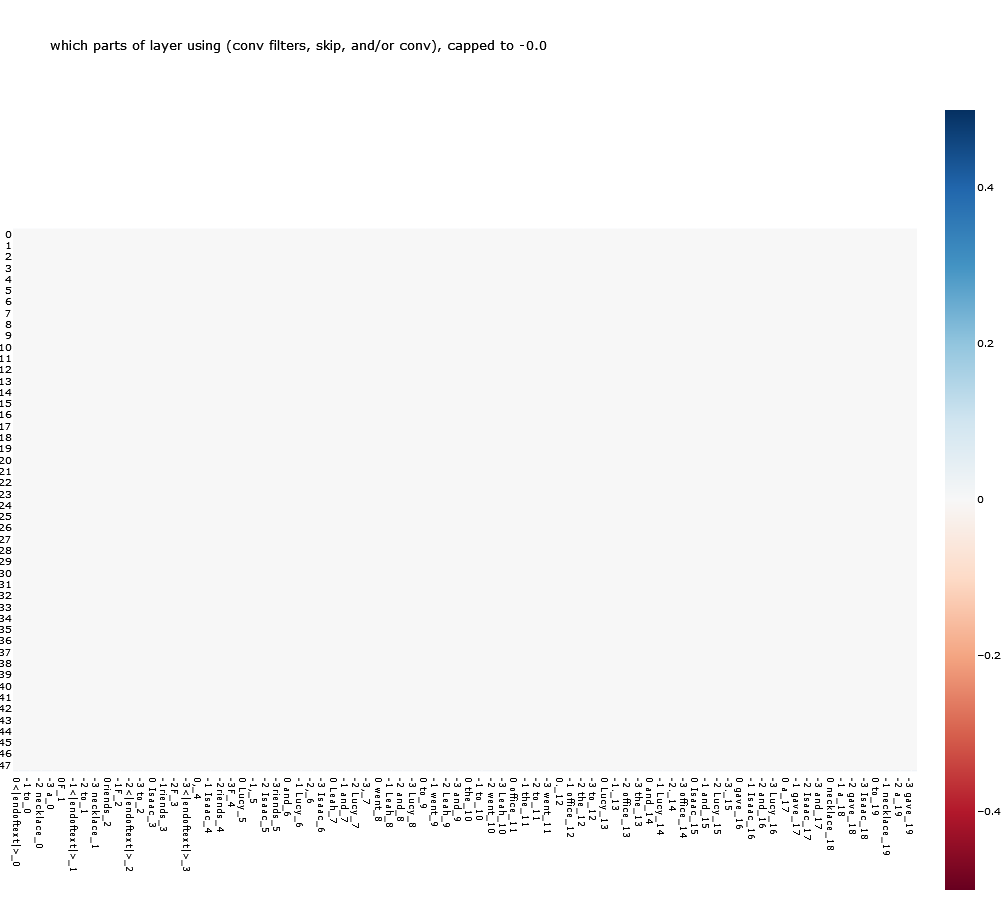

In [9]:
from acdc import ACDCEvalData
from transformer_lens.hook_points import HookPoint
import torch
from IPython.display import display, FileLink, Image
import acdc
from importlib import reload
edges = edges_to_keep
L = data.data.size()[1]
print(f"got L of {L}")
if POSITIONS:
    by_filters = torch.zeros([model.cfg.d_conv*L, model.cfg.n_layers])
else:
    by_filters = torch.zeros([model.cfg.d_conv, model.cfg.n_layers])

# change this to get the different plots
CAP = 0.0
# 1.0 is boolean (present or not)
# 0.0 is just give score

def filter_score(score):
    if CAP == 0.0: return score
    if CAP == 1.0: return 1.0
    return max(score, -CAP)
for edge in edges:
    if not edge.patching and edge.checked:
        if '.conv' in edge.output_node:
            if ":" in edge.label:
                pos = int(edge.label.split(":")[0][1:])
                rest = edge.label.split(":")[1]
            else:
                pos = None
                rest = edge.label[1:]
            filter = int(rest.split("]")[0])        
            layer = edge.output_node.split(".")[0]
            if POSITIONS:
                try:
                    by_filters[model.cfg.d_conv*pos + abs(int(filter)),int(layer)] = filter_score(edge.score_diff_when_patched)
                except:
                    print(L, pos, abs(int(filter)))
                    raise
            else:
                by_filters[abs(int(filter)),int(layer)] = filter_score(edge.score_diff_when_patched)
        if '.skip' in edge.output_node and False:        
            layer = edge.output_node.split(".")[0]
            by_filters[model.cfg.d_conv,int(layer)] = filter_score(edge.score_diff_when_patched)
        if '.ssm' in edge.output_node and False:
            layer = edge.output_node.split(".")[0]
            by_filters[model.cfg.d_conv+1,int(layer)] = filter_score(edge.score_diff_when_patched)
            

def layer_to_i(node):
    if node == INPUT_NODE:
        return 0
    elif node == OUTPUT_NODE:
        return model.cfg.n_layers+1 # because embed is 0
    else:
        return int(node)+1 # because embed is 0


def between_layers_info(edge):
    if edge.patching: return False, None, None
    is_between_layers = False
    layer_input = None
    layer_output = None
    if edge.input_node == INPUT_NODE:
        is_between_layers = True
        layer_input = INPUT_NODE
    if edge.output_node == OUTPUT_NODE:
        is_between_layers = True
        layer_output = OUTPUT_NODE

    if '.' in edge.input_node:
        input_layer, input_type = edge.input_node.split(".")
        if edge.input_node == output(input_layer):
            is_between_layers = True
            layer_input = str(input_layer)
    if '.' in edge.output_node:
        output_layer, output_type = edge.output_node.split(".")
        if edge.output_node == input(output_layer):
            is_between_layers = True
            layer_output = str(output_layer)
    return is_between_layers, layer_input, layer_output

def compute_adj_mat(edges):
    if POSITIONS:
        adj_mat = torch.zeros([L, model.cfg.n_layers+2, model.cfg.n_layers+2])
    else:
        adj_mat = torch.zeros([model.cfg.n_layers+2, model.cfg.n_layers+2])
    for edge in edges:
        is_between_layers, layer_input, layer_output = between_layers_info(edge)
        if is_between_layers:
            if POSITIONS:
                pos = int(edge.label)
                adj_mat[pos, layer_to_i(layer_input), layer_to_i(layer_output)] = edge.score_diff_when_patched
            else:
                adj_mat[layer_to_i(layer_input), layer_to_i(layer_output)] = edge.score_diff_when_patched
    return adj_mat


L = data.data.size()[1]
import networkx as nx
def better_get_nx_graph(adj_mat) -> nx.DiGraph:
    '''
    Converts the edges into a networkx graph
    only edges that have checked == True and patching == False are included
    if include_unchecked=True, any edge that has checked == False is also included
    '''
    num_nodes = adj_mat.size()[-1]
    G = nx.DiGraph()
    edges = []
    if POSITIONS:
        for pos in range(L):
            for i in range(num_nodes):
                for j in range(num_nodes):
                    if adj_mat[pos,i,j] != 0:
                        G.add_edge(str(i), str(j))
                        edges.append((i,j,pos,adj_mat[pos,i,j]))
    else:
        for i in range(num_nodes):
            for j in range(num_nodes):
                if adj_mat[i,j] != 0:
                    G.add_edge(str(i), str(j))
                    edges.append((i,j,None,adj_mat[i,j]))
    return G, edges

def better_prune_edges(adj_mat):
    num_nodes = adj_mat.size()[-1]
    input_node = 0
    output_node = num_nodes-1
    import networkx as nx
    G, edges = better_get_nx_graph(adj_mat=adj_mat)
    pruned_adj_mat = torch.zeros(adj_mat.size())
    pruned_edges = []
    for i,j,pos,attr in edges:
        connected_to_input = False
        try:
            to_input = nx.shortest_path(G, source=str(input_node), target=str(i))
            connected_to_input = True
        except nx.NetworkXNoPath:
            pass
        except nx.NodeNotFound:
            raise ValueError(f"Graph does not have input node {input_node}")
        
        connected_to_output = False
        try:
            to_output = nx.shortest_path(G, source=str(j), target=str(output_node))
            connected_to_output = True
        except nx.NetworkXNoPath:
            pass
        except nx.NodeNotFound:
            raise ValueError(f"Graph does not have output node {output_node}")
        #print(f"testing {i}->{j} {connected_to_input} {connected_to_output}")
        if connected_to_input and connected_to_output:
            pruned_adj_mat[pos,i,j] = attr
        else:
            print(f"pruning {pos} {i}->{j} {connected_to_input} {connected_to_output}")
    return pruned_adj_mat

adj_mat = compute_adj_mat(edges_to_keep)
pruned_adj_mat = better_prune_edges(adj_mat)

def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs and False:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    plot_args = {
        'width': 1200,
        'height': 900,
        "autosize": False,
        'showlegend': True,
        'margin': {"l":0,"r":0,"t":100,"b":0}
    }
    
    fig.update_layout(**plot_args)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
    if show:
        fig.show(renderer)
    else:
        return fig

def to_str(lis):
    return [str(x) for x in lis]
x_labels = to_str([-x for x in range(model.cfg.d_conv)])
toks = model.to_str_tokens(data.data[0])
x_labels_all_pos = []
for l in range(L):
    x_labels_all_pos += [label + toks[l+int(label)] + "_" + str(l) for label in x_labels]
print(x_labels, by_filters.size())
print(len(x_labels_all_pos))
title = f'which parts of layer using (conv filters, skip, and/or conv), capped to {-CAP}'
if CAP == 1.0:
    title = f'which parts of layer using (conv filters, skip, and/or conv)'
print(x_labels_all_pos)
imshow(by_filters.T, y=to_str(range(model.cfg.n_layers)), x=x_labels_all_pos, title=title, font_size=9)
#for layer in range(model.cfg.n_layers):
#    imshow(by_filters[:,layer:layer+1].T, y=to_str([layer]), x=x_labels_all_pos, title=str(layer), font_size=9)

labels = ['embed'] + [str(x) for x in range(model.cfg.n_layers)] + ['output']
if POSITIONS:
    for position in range(L):
        if torch.any(pruned_adj_mat[position] != 0):
            imshow(pruned_adj_mat[position], y=labels, x=labels, title=f'pos {position} tok {toks[position]} adjacency matrix clamped to {CAP}', font_size=8)
else:
    imshow(pruned_adj_mat, y=labels, x=labels, title=f'adjacency matrix clamped to {CAP}', font_size=8)


In [51]:
name_positions = [3,5,7,13,15]
position_map = {}
for l in range(L):
    position_map[l] = f'pos{l}{toks[l]}'
position_map[3] = 'n1'
position_map[5] = 'n2'
position_map[7] = 'n3'
position_map[13] = 'n4'
position_map[15] = 'n5'
position_map[19] = 'out'



for layer in range(model.cfg.n_layers):
    layer_attrs = []
    for l in range(L):
        for filter_i in range(model.cfg.d_conv):
            filter_offset = -filter_i
            index = l*model.cfg.d_conv + filter_i
            attr = by_filters[index, layer]
            if attr < 0:
                layer_attrs.append((position_map[l+filter_offset], attr, filter_offset))
    print(layer)
    for tok, attr, filter_offset in layer_attrs:
        attr = -attr*1000
        print(f"  {tok}[{filter_offset}] {attr:.5f}")

def map_layer(layer):
    if layer == 0: return 'embed'
    if layer == model.cfg.n_layers+1: return 'output'
    else: return str(layer-1)

for layer in range(model.cfg.n_layers+2):
    layer_attrs = []
    for other_layer in range(model.cfg.n_layers+2):
        for pos in range(L):
            if pruned_adj_mat[pos, layer, other_layer] != 0:
                layer_attrs.append((position_map[pos], f"->{map_layer(other_layer)}", pruned_adj_mat[pos, layer, other_layer]))
            if pruned_adj_mat[pos, other_layer, layer] != 0:
                layer_attrs.append((position_map[pos], f"{map_layer(other_layer)}->", pruned_adj_mat[pos, other_layer, layer]))
    print(map_layer(layer))
    for tok, label, attr in layer_attrs:
        attr = -attr*1000
        print(f"  {tok} {label} {attr:.5f}")


0
  pos0<|endoftext|>[-1] 0.01569
  n1[0] 0.04197
  n2[0] 0.09571
  n3[0] 0.11208
  n4[0] 0.17028
  n5[0] 0.19289
1
  n1[-1] 0.01817
2
  pos2riends[0] 0.04339
  n3[-1] 0.01462
  n4[0] 0.02735
  n5[0] 0.01432
3
  pos1F[0] 0.01117
  pos0<|endoftext|>[-1] 0.01573
  pos2riends[0] 0.01082
  n1[0] 0.01472
  pos2riends[-1] 0.03969
  n1[-1] 0.04919
  pos4,[-1] 0.01569
  n2[-1] 0.04476
  n3[-1] 0.01805
  n4[0] 0.02013
  n5[0] 0.01700
4
  pos8 went[-1] 0.01502
  pos12.[0] 0.01783
  n4[0] 0.01365
5
  pos1F[0] 0.01174
  pos1F[-1] 0.01189
  n4[0] 0.03053
  n5[0] 0.02402
6
  n2[-1] 0.01191
  pos9 to[-1] 0.07607
  pos12.[0] 0.03377
  n4[0] 0.05327
  pos12.[-1] 0.01779
  pos14 and[0] 0.02454
  n5[0] 0.04239
  out[0] 0.05218
7
  pos1F[0] 0.00896
  n4[0] 0.03533
  pos14 and[0] 0.01168
  n5[0] 0.03383
  pos18 necklace[0] 0.01329
  out[0] 0.05075
8
  pos2riends[0] 0.01729
  pos16 gave[0] 0.02023
  pos16 gave[-1] 0.02449
  pos18 necklace[0] 0.01455
  pos18 necklace[-1] 0.01268
9
  pos4,[-1] 0.01173
  pos8 

pruning 15 10->40 False True
pruning 15 33->35 False True
pruning 15 33->40 False True
pruning 19 33->34 False True
pruning 19 33->37 False True
pruning 19 33->40 False True
pruning 19 34->41 True False
{11, 12, 13, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 43, 46, 47}


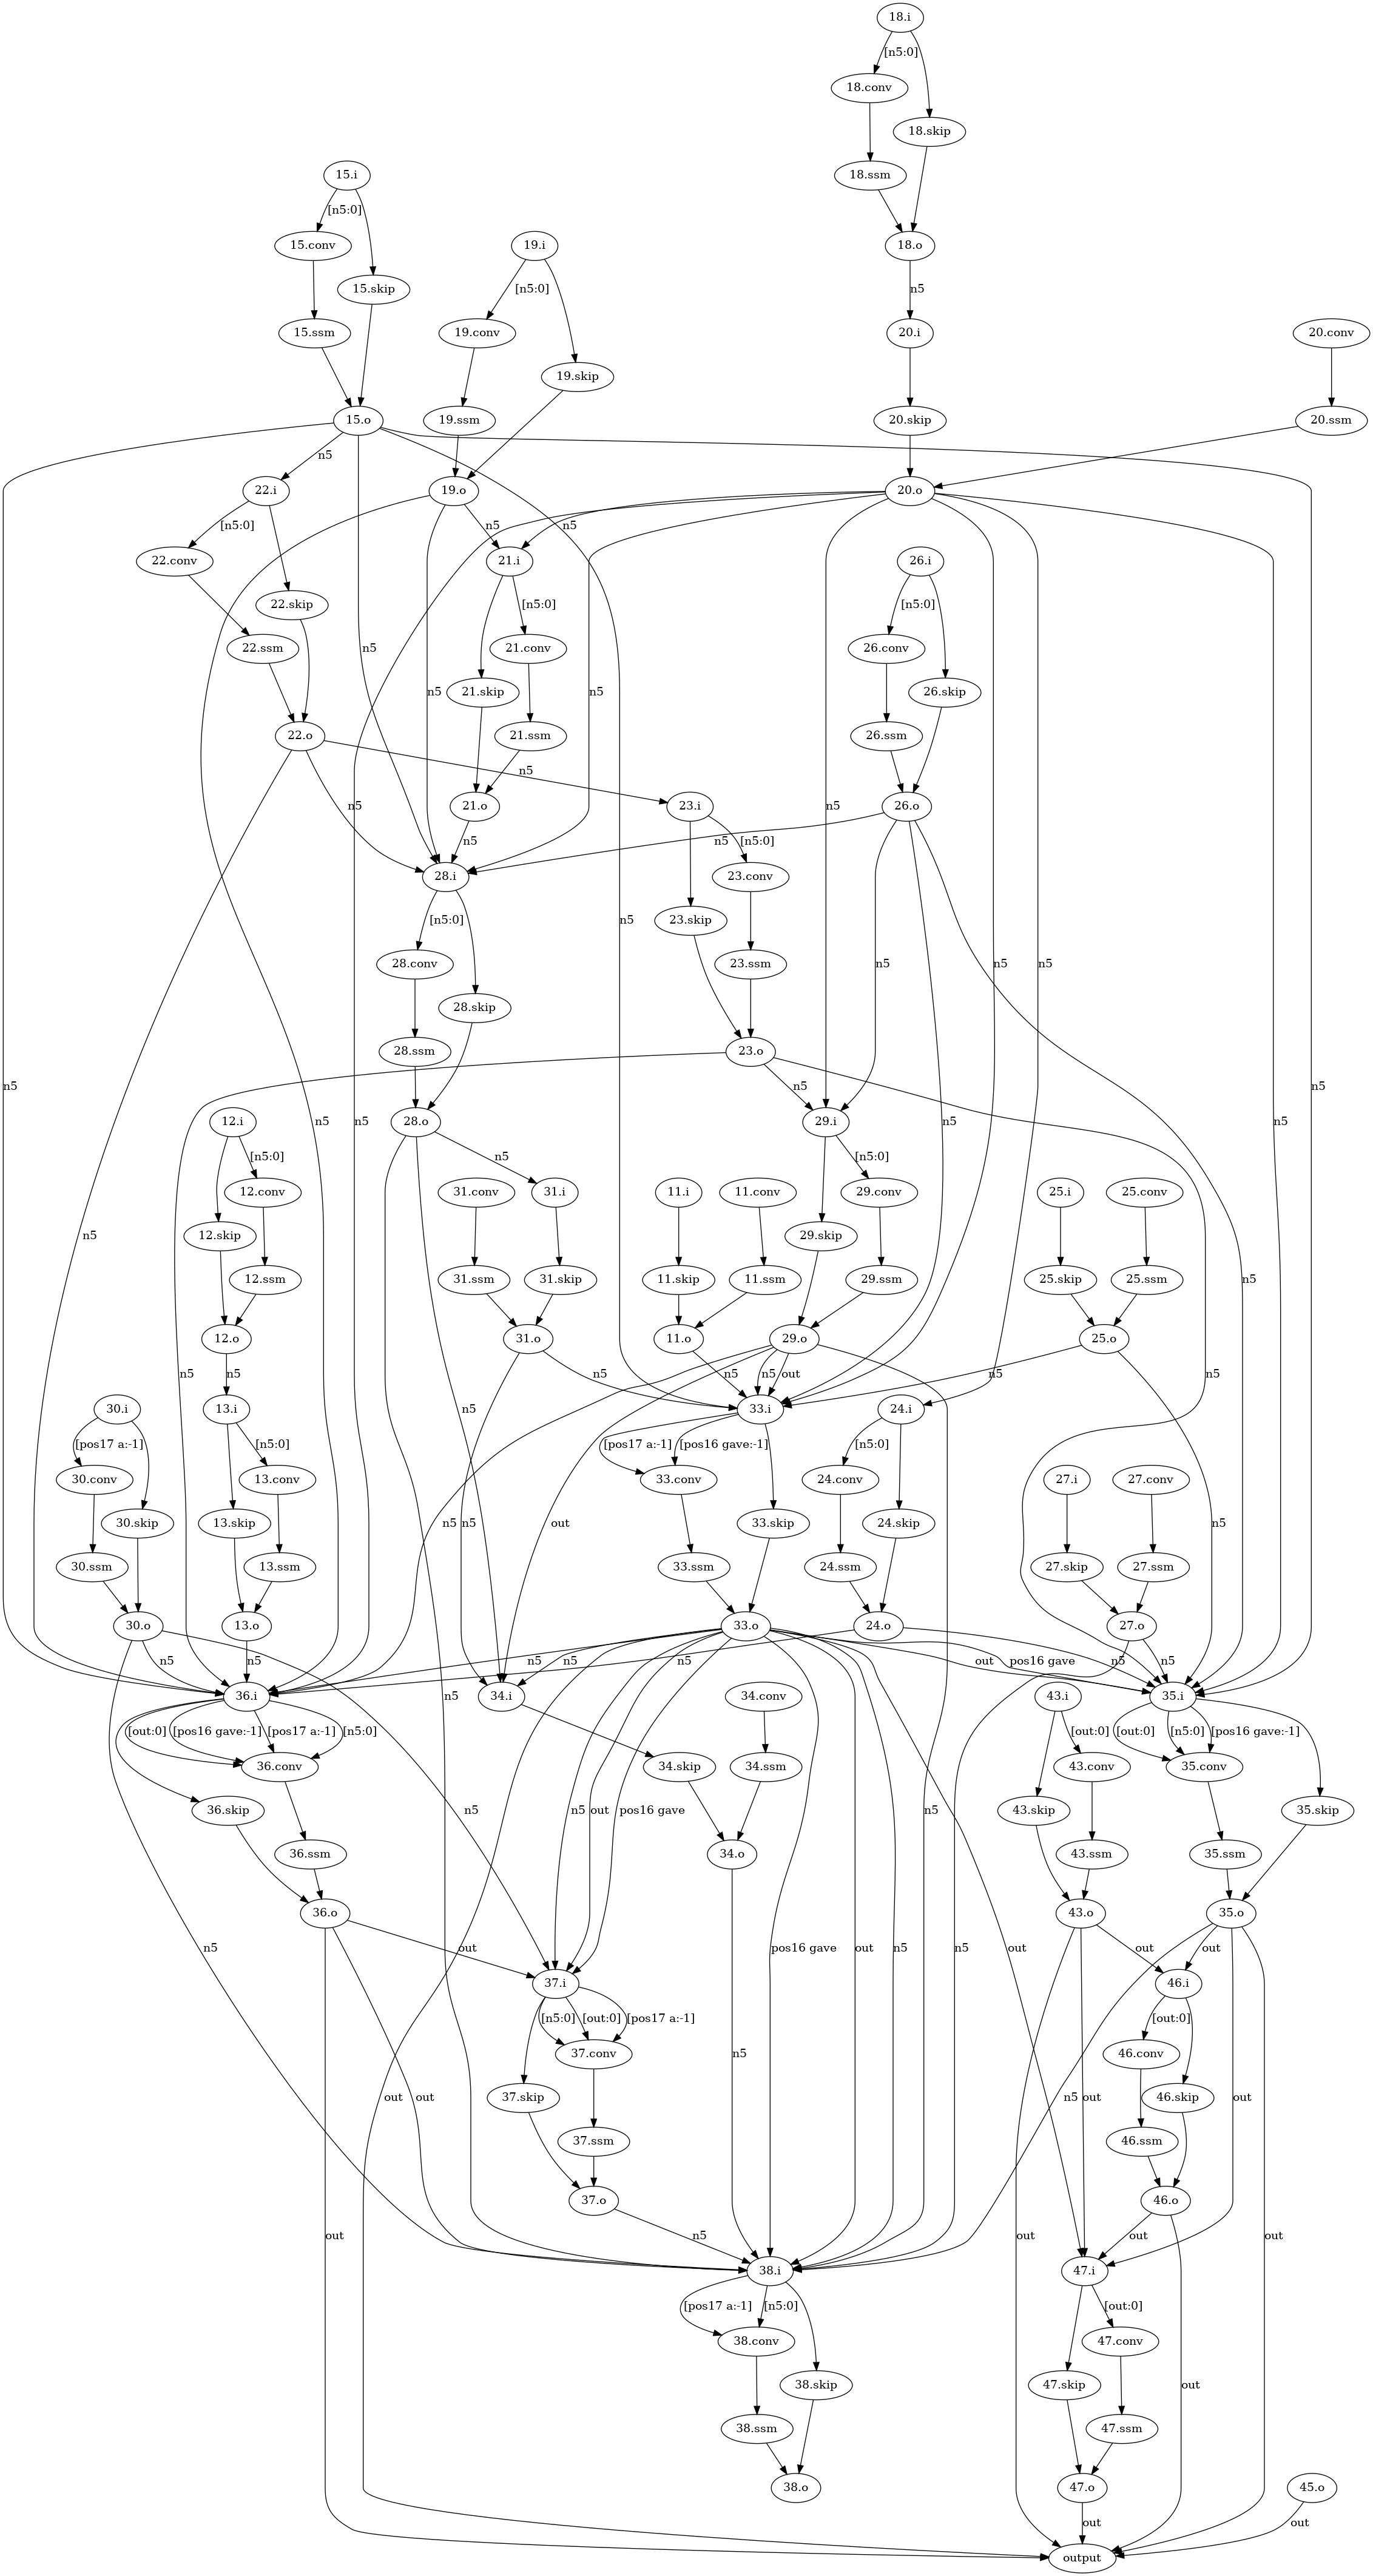

/home/dev/mamba_interp/pruned dot 0.85.png

In [43]:
import graphviz
def layer_to_i(layer):
    if layer == 'embed': return 0
    elif layer == 'output': return model.cfg.n_layers+1
    else: return int(layer)+1

forbidden = [0,1,40]
pruned_adj_mat = better_prune_edges(adj_mat)
for i in forbidden:
    pruned_adj_mat[:,i,:] = 0
    pruned_adj_mat[:,:,i] = 0
present_layers = set()
for i in range(model.cfg.n_layers):
    for j in range(model.cfg.n_layers):
        if not i+1 in forbidden and not j+1 in forbidden:
            if torch.any(pruned_adj_mat[:,i+1,j+1] != 0):
                present_layers.add(i)
                present_layers.add(j)
                #print(f"present edge {i}->{j}")
print(present_layers)
pruned_dot = graphviz.Digraph('graph')
for edge in edges_to_keep:
    is_between_layers, layer_input, layer_output = between_layers_info(edge)
    if is_between_layers:
        ini, outi = layer_to_i(layer_input), layer_to_i(layer_output)
        pos = int(edge.label)
        if pruned_adj_mat[pos, ini, outi] != 0:
            if not ini in forbidden and not outi in forbidden:
                pruned_dot.edge(edge.input_node, edge.output_node, label=position_map[int(edge.label)])
    else:
        layer = int(edge.input_node.split(".")[0])
        if layer in present_layers: # don't display stuff that are disconnected
            if '.ssm' in edge.output_node or '.skip' in edge.output_node or '.skip' in edge.input_node: # don't need all these since they are all forced on
                if edge.label == 0 or edge.label == "" or edge.label is None or edge.label == "0":
                    pruned_dot.edge(edge.input_node, edge.output_node)
            elif '.conv' in edge.output_node:
                label = edge.label
                # replace pos: with the more helpful labels
                for l in range(L):
                    start_from_back = L-l-1 # start from biggest number work backwards because like 10 contains a 1 so we need to do 10 first
                    prev_label = label
                    label = label.replace("[" + str(start_from_back) + ":", "[" + position_map[start_from_back] + ":")
                    if label != prev_label:
                        break
                pruned_dot.edge(edge.input_node, edge.output_node, label=label)
            else:
                pruned_dot.edge(edge.input_node, edge.output_node, label=edge.label)
output_name = f'pruned dot {ACC_THRESH}'
pruned_dot.render(output_name, format="png") # it automatically appends png
display(Image(filename=output_name + ".png"))
display(FileLink(output_name + ".png"))

In [42]:
import pickle
with open("cached_sae_feature_edges.pkl", "wb") as f:
    pickle.dump(edges_to_keep, f)


In [43]:
with open("cached_sae_feature_edges.pkl", "rb") as f:
    edges_to_keep = pickle.load(f)
toks = model.to_str_tokens(data.data[0])
name_positions = [3,5,7,13,15]
position_map = {}
for l in range(L):
    position_map[l] = f'pos{l}{toks[l]}'
position_map[3] = 'n1'
position_map[5] = 'n2'
position_map[7] = 'n3'
position_map[13] = 'n4'
position_map[15] = 'n5'
position_map[19] = 'out'


print(len(edges_to_keep))
sae_edges = defaultdict(lambda: defaultdict(lambda: []))
counts = defaultdict(lambda: defaultdict(lambda: 0))
num_to_show = 400
iters = 0

for edge in edges_to_keep:
    if '.sae' in edge.output_node and not edge.label is None:
        # [pos:feature_i]
        label = edge.label[1:-1]
        pos, feature_i = label.split(":")
        pos = int(pos)
        if feature_i == 'KEEP': continue # dummy edge used to ensure sae always applied
        iters += 1
        feature_i = int(feature_i)
        layer = int(edge.output_node.split(".")[0])
        attr = edge.score_diff_when_patched
        sae_edges[layer][pos].append((attr, feature_i))
        counts[layer][feature_i] += 1
        print(layer, pos, position_map[pos], feature_i, attr)
        #print(layer, pos, feature_i, attr)
        if iters > num_to_show: break

8487
15 13 n4 15921 -1.4511811931733973
15 13 n4 11839 -1.1555863783723908
20 15 n5 27256 -1.0338027551188134
20 13 n4 23228 -0.9890130006533582
20 13 n4 2724 -0.9646386316744611
15 13 n4 25771 -0.8934519871108932
15 15 n5 26824 -0.8928024366832688
20 13 n4 23731 -0.844180965796113
15 15 n5 11839 -0.8429616270004772
15 15 n5 27758 -0.8418691491242498
14 15 n5 13971 -0.7999667014519218
15 13 n4 17259 -0.7739449571818113
20 15 n5 2724 -0.737606625945773
15 15 n5 31021 -0.6951032060023863
15 13 n4 7440 -0.6218199331851793
15 15 n5 8113 -0.6123286176807596
15 13 n4 8113 -0.6059157950221561
20 15 n5 25369 -0.5720785861194599
15 13 n4 6146 -0.5615684384829365
20 13 n4 25369 -0.5487742855912074
15 13 n4 26824 -0.5487118880992057
15 13 n4 31021 -0.5430846622330137
19 5 n2 30561 -0.5199790453916648
20 15 n5 23228 -0.5164780604463886
15 13 n4 28222 -0.5075037965434603
14 13 n4 13971 -0.4765838644379983
14 15 n5 32567 -0.4751656675944105
11 13 n4 22965 -0.46325298480223864
15 15 n5 6146 -0.451987

In [ ]:


total_num_features = 0
for layer in sorted(list(sae_edges.keys())):
    print(f"layer {layer} with {len(counts[layer])} unique features ({len([x for x in counts[layer] if x > 1])} duplicated)")
    total_num_features += len(counts[layer])
    values = sae_edges[layer]
    for pos in sorted(list(values.keys())):
        print(f"  pos {position_map[pos]} num sae {len(values[pos])} min attr scaled {'{:.3f}'.format(1000*min([x[0] for x in values[pos]]))}")
print(f"total num features {total_num_features}")

In [77]:
from dataclasses import dataclass, field

def get_batched_index_into(indices):
    '''
    given data that is [B,N,V] and indicies that are [B,N,K] with each index being an index into the V space
    this gives you indexes you can use to access your values
    '''
    first_axis = []
    second_axis = []
    third_axis = []
    B, _, _ = indices.size()
    for b in range(B):
        second, third = get_index_into(indices[b])
        first_axis.append(torch.full(second.size(), fill_value=b, device=model.cfg.device))
        second_axis.append(second)
        third_axis.append(third)

    return torch.cat(first_axis), torch.cat(second_axis), torch.cat(third_axis)

def get_index_into(indices):
    '''
    given data that is [N,V] and indicies that are [N,K] with each index being an index into the V space
    this gives you indexes you can use to access your values
    '''
    num_data, num_per_data = indices.size()
    # we want
    # [0,0,0,...,] num per data of these
    # [1,1,1,...,] num per data of these
    # ...
    # [num_data-1, num_data-1, ...]
    first_axis_index = torch.arange(num_data, dtype=torch.long).view(num_data, 1)*torch.ones([num_data, num_per_data], dtype=torch.long)
    # now we flatten it so it has an index for each term aligned with our indices
    first_axis_index = first_axis_index.flatten()
    second_axis_index = indices.flatten()
    return first_axis_index, second_axis_index
global buffer
buffer = None
global features_by_layer
def sae_hook(
    x,
    hook,
    layer,
):
    # s is [B,L,E]
    K = saes[layer].cfg.k
    sae = saes[layer]
    B,L,D = x.size()
    uncorrupted_features = sae.encode(x)
    top_acts, top_indices = uncorrupted_features.topk(K, sorted=False)
    global buffer
    if buffer is None:
        buffer = torch.zeros(uncorrupted_features.size(), device=model.cfg.device)
    buffer[:] = 0
    
    # zero everything except the top k
    buffer[get_batched_index_into(top_indices)] = top_acts.flatten()
    for feature in features_by_layer[layer]:
        feature.records += [x.item() for x in buffer[:,feature.pos,feature.feature_i]]
    # kernel can't handle doing all token positions at same time by default
    # but if we make it think B*L is a single batch index it works fine
    top_acts_flattened = top_acts.flatten(start_dim=0, end_dim=1)
    top_indices_flattened = top_indices.flatten(start_dim=0, end_dim=1)
    sae_out = sae.decode(top_acts_flattened, top_indices_flattened)
    sae_out = sae_out.unflatten(dim=0, sizes=(B,L))
    return sae_out



@dataclass
class SAEFeature:
    """Class for keeping track of an item in inventory."""
    layer: int
    pos: int
    feature_i: int
    attr: float
    records: list = field(default_factory=lambda: [])

    def __repr__(self):
        return str(self.layer) + " " + str(self.pos) + " " + str(self.feature_i) + " " + str(self.attr)

    def __str__(self):
        return self.__repr__()

def parse_feature(feature_str):
    layer, pos, pos_name, feature_i, attr = feature_str.split()
    layer = int(layer)
    pos = int(pos)
    feature_i = int(feature_i)
    attr = float(attr)
    return SAEFeature(layer=layer, pos=pos, feature_i=feature_i, attr=attr)
features = """
15 13 n4 15921 -1.4511811931733973
15 13 n4 11839 -1.1555863783723908
20 15 n5 27256 -1.0338027551188134
20 13 n4 23228 -0.9890130006533582
20 13 n4 2724 -0.9646386316744611
15 13 n4 25771 -0.8934519871108932
15 15 n5 26824 -0.8928024366832688
20 13 n4 23731 -0.844180965796113
15 15 n5 11839 -0.8429616270004772
15 15 n5 27758 -0.8418691491242498
14 15 n5 13971 -0.7999667014519218
15 13 n4 17259 -0.7739449571818113
20 15 n5 2724 -0.737606625945773
15 15 n5 31021 -0.6951032060023863
15 13 n4 7440 -0.6218199331851793
15 15 n5 8113 -0.6123286176807596
15 13 n4 8113 -0.6059157950221561
20 15 n5 25369 -0.5720785861194599
15 13 n4 6146 -0.5615684384829365
20 13 n4 25369 -0.5487742855912074
15 13 n4 26824 -0.5487118880992057
15 13 n4 31021 -0.5430846622330137
19 5 n2 30561 -0.5199790453916648
20 15 n5 23228 -0.5164780604463886
15 13 n4 28222 -0.5075037965434603
14 13 n4 13971 -0.4765838644379983
14 15 n5 32567 -0.4751656675944105
11 13 n4 22965 -0.46325298480223864
15 15 n5 6146 -0.45198706406517886
19 15 n5 30740 -0.43911108660540776
20 15 n5 29653 -0.43348417259403504
15 15 n5 8935 -0.4290462978715368
20 15 n5 8196 -0.40242351567940204
15 15 n5 16138 -0.4004057846032083
19 3 n1 30561 -0.3884095794055611
20 15 n5 1899 -0.3876068123790901
20 5 n2 27256 -0.3814757227519294
15 13 n4 2344 -0.38085291545576183
19 15 n5 30561 -0.37879287756368285
15 15 n5 22790 -0.37808844797109487
15 15 n5 2344 -0.3775725119630806
15 13 n4 12167 -0.3703001577523537
21 15 n5 7554 -0.34814969086801284
21 13 n4 7554 -0.34735435343463905
14 13 n4 32567 -0.3427205775587936
15 15 n5 29892 -0.33304538365337066
20 15 n5 23731 -0.33183777012163773
15 15 n5 8649 -0.3311291775389691
15 13 n4 2380 -0.32058422826230526
15 15 n5 1349 -0.317370749762631
15 15 n5 28979 -0.3154674572579097
15 13 n4 30976 -0.3153745725285262
20 13 n4 17612 -0.31191760893852916
15 13 n4 22801 -0.3013547840891988
12 15 n5 6008 -0.30098827754409285
12 15 n5 4851 -0.2981748393503949
20 13 n4 1899 -0.29404354887083173
14 5 n2 13971 -0.29324889490089845
15 13 n4 22790 -0.28884116747940425
15 15 n5 17259 -0.2834519026146154
19 5 n2 9076 -0.28338390760472976
20 5 n2 23228 -0.2785688600561116
15 13 n4 29892 -0.2779534184228396
20 15 n5 24925 -0.27310544914143975
15 13 n4 32240 -0.2724338702391833
19 7 n3 30561 -0.27105611146544106
20 13 n4 29653 -0.26252533006481826
19 13 n4 30740 -0.26012522503879154
20 5 n2 25369 -0.25853115250356495
11 13 n4 19600 -0.2510134789190488
20 15 n5 6758 -0.24530868871806888
15 7 n3 8935 -0.24060688240570016
11 13 n4 18719 -0.23991555671091191
15 13 n4 28979 -0.23681864549871534
20 15 n5 17612 -0.23483685902829166
15 3 n1 25771 -0.22723528533242643
15 15 n5 17920 -0.22721617101342417
20 15 n5 6986 -0.22323725407477468
14 15 n5 28831 -0.22306419239612296
15 15 n5 22801 -0.22277752275113016
20 13 n4 24925 -0.22063778418123547
15 3 n1 8113 -0.21664783913001884
11 15 n5 19600 -0.21422454587991524
16 15 n5 19800 -0.21313862562237773
20 13 n4 27256 -0.2103884415628272
15 7 n3 26824 -0.208646113776922
14 5 n2 32567 -0.20791079929767875
20 15 n5 10083 -0.20755451168952277
11 15 n5 18719 -0.20682069531903835
15 15 n5 30976 -0.20519282953318907
15 15 n5 10252 -0.19859311032632831
20 5 n2 8455 -0.19858658533848939
20 13 n4 3156 -0.18876934882428031
20 5 n2 2724 -0.1882108402205631
20 13 n4 6986 -0.18641833098081406
20 3 n1 25369 -0.18377804876945447
20 13 n4 1672 -0.18313410242262762
20 7 n3 17612 -0.17767891606126796
14 3 n1 13971 -0.177633166378655
20 13 n4 31901 -0.17577282109414227
15 5 n2 27758 -0.1747781486083113
15 7 n3 2380 -0.174283399428532
15 15 n5 9746 -0.1737501583957055
20 3 n1 29653 -0.17337747645069612
15 5 n2 26824 -0.16980820387470885
15 13 n4 1349 -0.16958206321578473
15 3 n1 2344 -0.16653591250360478
20 13 n4 15013 -0.16628824583312962
19 15 n5 27888 -0.16485086461761966
14 13 n4 28831 -0.16269497356734064
15 15 n5 25903 -0.15941790843498893
20 15 n5 1672 -0.15898824847317883
21 7 n3 6419 -0.15865897008188767
15 15 n5 3888 -0.1581162586571736
20 7 n3 8455 -0.1577744372516463
19 13 n4 9076 -0.15575948629702907
15 15 n5 25771 -0.15522614054498263
1 15 n5 25764 -0.15266994523699395
15 15 n5 12167 -0.15147657443594653
15 15 n5 15921 -0.15116392161144176
15 3 n1 31021 -0.1500888324371772
20 3 n1 23228 -0.14868561428011162
11 5 n2 19600 -0.147709660937835
15 13 n4 25903 -0.1476323436727398
15 15 n5 26556 -0.1475745009338425
14 7 n3 13971 -0.1464709811261855
20 13 n4 10083 -0.14522044641853427
21 5 n2 7554 -0.14491799040115438
11 7 n3 19600 -0.1438251133004087
20 7 n3 27256 -0.14189712883853645
15 3 n1 28222 -0.14156844822718995
15 7 n3 27758 -0.13967746320849983
20 13 n4 6758 -0.1395779878639587
16 5 n2 8413 -0.1384436698135687
15 15 n5 15762 -0.1374775571275677
15 5 n2 25771 -0.1365963689131604
14 7 n3 28831 -0.13502024069566687
18 13 n4 24113 -0.13279320938272576
20 3 n1 23731 -0.13276870549452724
20 3 n1 24925 -0.12945301840591128
15 5 n2 11839 -0.12674832851189421
20 15 n5 1336 -0.12278529405011795
20 3 n1 1899 -0.12241411584545858
20 7 n3 6758 -0.12176360644843953
20 15 n5 21539 -0.1217278007643472
15 13 n4 9187 -0.11823179898783565
20 15 n5 13117 -0.11767573590623215
15 7 n3 31021 -0.11718380186539434
11 7 n3 18719 -0.11692520580254495
10 7 n3 11071 -0.11588574545021402""".strip()
features = [parse_feature(line.strip()) for line in features.split("\n")]

from tqdm import tqdm
def forward_check_features(data, features, batch_size):
    
    global features_by_layer

    features_by_layer = defaultdict(lambda: [])
    for feature in features:
        feature.records = []
        features_by_layer[feature.layer].append(feature)

    # only bother with SAE on the layers we are checking
    layers_to_apply_sae = sorted(list(features_by_layer.keys()))
    hooks = [(f'blocks.{layer}.hook_out_proj', partial(sae_hook, layer=layer)) for layer in layers_to_apply_sae]

    DATA_LEN = data.data.size()[0]
    for batch_start in tqdm(list(range(0, DATA_LEN, batch_size))):
        batch_end = min(DATA_LEN, batch_start+batch_size)
        data_batch = data.data[batch_start:batch_end]
        _ = model.run_with_hooks(input=data_batch, fwd_hooks=hooks, fast_ssm=True, fast_conv=True)
    

import acdc.data.ioi

with open("/home/dev/mamba_interp/MoreNames.txt", "r") as f:
    all_names = [x.strip() for x in f.read().split("\n") if len(x.strip()) > 0]
    # regenerate names, but more
    acdc.data.ioi.NAMES = sorted(list(set(all_names)))
    acdc.data.ioi.good_names = None 

data = make_data(num_patching_pairs=50000, patching='all', template_i=0, seed=29, valid_seed = 41)
print("num names ", len(acdc.data.ioi.good_names))
forward_check_features(data=data, features=features, batch_size=200)




using patching format
ABC AB C
ABC AC B

ABC AB C
ABC CB A

ABC AB C
ABD AB D

ABC AC B
ABC BC A

ABC AC B
ADC AC D

ABC BA C
ABC BC A

ABC BA C
ABC CA B

ABC BA C
ABD BA D

ABC BC A
DBC BC D

ABC CA B
ABC CB A

ABC CA B
ADC CA D

ABC CB A
DBC CB D

using templates
Then, [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
with name positions (2, 4, 6, 12, 14)
removed jesus
['<|endoftext|>', 'Then', ',', ' Hogan', ',', ' Stephen', ' and', ' Jensen', ' went', ' to', ' the', ' house', '.', ' Stephen', ' and', ' Hogan', ' gave', ' a', ' apple', ' to']
['<|endoftext|>', 'Then', ',', ' Hogan', ',', ' Stephen', ' and', ' Jensen', ' went', ' to', ' the', ' house', '.', ' Stephen', ' and', ' Jensen', ' gave', ' a', ' apple', ' to']
num names  978


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [20:13<00:00,  1.21s/it]


In [86]:
def extract_template(data_point):
    a,b,c,d,e = data_point[3], data_point[5], data_point[7], data_point[13], data_point[15]
    lookup = {}
    template = ""
    order = 'ABCDEF'
    order_ind = 0
    for name in [a,b,c,d,e]:
        if not name in lookup:
            lookup[name] = order[order_ind]
            order_ind += 1
        template += lookup[name]
    return template


for feature in features:
    print(feature, position_map[feature.pos])
    name_counts = {}
    DATA_LEN = len(feature.records)
    records_tensor = torch.tensor(feature.records)
    non_zero_indices = torch.arange(DATA_LEN)[records_tensor!=0]
    non_zero_tokens = data.data[non_zero_indices,feature.pos].cpu()
    non_zero_records = records_tensor[non_zero_indices]
    name_tokens = torch.unique(non_zero_tokens)
    for name_token in name_tokens:
        name_str = model.to_str_tokens(name_token.view(1,1))[0]
        name_counts[name_str] = non_zero_records[non_zero_tokens==name_token.item()]
    #for t,c in template_counts.items():
    #    print(f" template {t} with count {torch.mean(torch.tensor(c)).item()}")
    name_counts = sorted(list(name_counts.items()), key=lambda x: -torch.mean(x[1]).item())
    for n,c in name_counts[:100]:
        print(f" name {n} with avg {torch.mean(c).item()} min {torch.min(c).item()} max {torch.max(c).item()}")

15 13 15921 -1.4511811931733973 n4
 name  Penny with avg 1.2816493511199951 min 0.9874134063720703 max 1.4943379163742065
 name  Perry with avg 1.1376900672912598 min 0.880638837814331 max 1.3143985271453857
 name  Parker with avg 1.1307227611541748 min 0.910876989364624 max 1.3317008018493652
 name  Pam with avg 1.1057740449905396 min 0.7598392963409424 max 1.2847601175308228
 name  Phillip with avg 1.0750831365585327 min 0.8962874412536621 max 1.352374792098999
 name  Paulo with avg 1.0700784921646118 min 0.9333256483078003 max 1.2313556671142578
 name  Pierre with avg 1.0305426120758057 min 0.7701814770698547 max 1.3329890966415405
 name  Pedro with avg 1.0119385719299316 min 0.7955439686775208 max 1.1998956203460693
 name  Preston with avg 0.9997744560241699 min 0.7364502549171448 max 1.1313331127166748
 name  Philippe with avg 0.9894717335700989 min 0.6206800937652588 max 1.1372209787368774
 name  Pearl with avg 0.9830290079116821 min 0.7537078261375427 max 1.131029725074768
 name